<a href="https://colab.research.google.com/github/nn-fiha/sentiment-analysis/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install pandas nltk spacy emoji transformers tokenizers torch scikit-learn wordcloud vaderSentiment tqdm --quiet
!python -m spacy download en_core_web_sm
!pip install pandas deep-translator nltk emoji --quiet
!pip install langdetect deep-translator nltk spacy emoji --quiet
!python -m spacy download en_core_web_sm

!pip install vaderSentiment --quiet
!pip install --upgrade huggingface-hub

# Imports
import pandas as pd
import re
import nltk
import spacy
import emoji
from nltk.corpus import stopwords
from transformers import BertTokenizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
tqdm.pandas()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 23.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.l

In [ ]:
# -----------------------------
# Load Dataset
# -----------------------------
df = pd.read_csv('/content/drive/MyDrive/sentiment analysis/sentiment dataset.csv')
print("Dataset shape:", df.shape)
df.head()

# -----------------------------
# Initialize Resources
# -----------------------------
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
analyzer = SentimentIntensityAnalyzer()

Dataset shape: (37123, 9)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 2: Clean and Translate Text

In [ ]:
from langdetect import detect
from deep_translator import GoogleTranslator

# Only translate non-English text
def is_english(text):
    try:
        return detect(text) == 'en'
    except:
        return False

def translate_text(text):
    if not is_english(text):
        try:
            return GoogleTranslator(source='auto', target='en').translate(text)
        except:
            return text
    return text

df['translated_text'] = df['text'].astype(str).progress_apply(translate_text)
print("\n Translating non-English content to English...")

# Show sample translations
print("\n Sample translations:")
print(df[['text', 'translated_text']].head(5))

# Clean text (keep stopwords for model, remove for analysis later)
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text) # URLs
    text = re.sub(r'@\w+', '', text)                      # mentions
    text = re.sub(r'#\w+', '', text)                      # hashtags
    text = emoji.replace_emoji(text, replace='')          # emojis
    text = re.sub(r'[^\w\s]', '', text)                  # punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['translated_text'].astype(str).progress_apply(clean_text)
# Show cleaned text
print("\n Sample after cleaning:")
print(df[['translated_text', 'clean_text']].head(5))


100%|██████████| 37123/37123 [13:48<00:00, 44.82it/s]



 Translating non-English content to English...

 Sample translations:
                                                text  \
0  “I am utterly disgusted… This is an insult to ...   
1  AI models don't magically know how to generate...   
2  Midjourney with Veo 3-level prompt coherence (...   
3  So this is AI animation. And it's disturbing t...   
4  Think You Need ChatGPT-4o for That Dreamy Ghib...   

                                     translated_text  
0  “I am utterly disgusted… This is an insult to ...  
1  AI models don't magically know how to generate...  
2  Midjourney with Veo 3-level prompt coherence (...  
3  So this is AI animation. And it's disturbing t...  
4  Think You Need ChatGPT-4o for That Dreamy Ghib...  


100%|██████████| 37123/37123 [00:08<00:00, 4191.88it/s]


 Sample after cleaning:
                                     translated_text  \
0  “I am utterly disgusted… This is an insult to ...   
1  AI models don't magically know how to generate...   
2  Midjourney with Veo 3-level prompt coherence (...   
3  So this is AI animation. And it's disturbing t...   
4  Think You Need ChatGPT-4o for That Dreamy Ghib...   

                                          clean_text  
0  i am utterly disgusted this is an insult to li...  
1  ai models dont magically know how to generate ...  
2  midjourney with veo 3level prompt coherence it...  
3  so this is ai animation and its disturbing to ...  
4  think you need chatgpt4o for that dreamy ghibl...  


Step 3: Subword Tokenization (Keep stopwords for models)

In [ ]:
def subword_tokenize(text):
    return tokenizer.tokenize(text)

df['subword_tokens'] = df['clean_text'].progress_apply(subword_tokenize)

# Show tokenized text
print("\n Sample after Subword Tokenization:")
print(df[['clean_text', 'subword_tokens']].head(5))

100%|██████████| 37123/37123 [00:20<00:00, 1829.27it/s]


 Sample after Subword Tokenization:
                                          clean_text  \
0  i am utterly disgusted this is an insult to li...   
1  ai models dont magically know how to generate ...   
2  midjourney with veo 3level prompt coherence it...   
3  so this is ai animation and its disturbing to ...   
4  think you need chatgpt4o for that dreamy ghibl...   

                                      subword_tokens  
0  [i, am, utterly, disgusted, this, is, an, insu...  
1  [ai, models, don, ##t, magical, ##ly, know, ho...  
2  [mid, ##jou, ##rney, with, ve, ##o, 3, ##lev, ...  
3  [so, this, is, ai, animation, and, its, distur...  
4  [think, you, need, chat, ##gp, ##t, ##4, ##o, ...  


Step 4: Optional Stopword Removal for Analysis/Wordcloud

In [ ]:
def remove_stopwords(text):
    return ' '.join([w for w in text.split() if w not in stop_words])

df['clean_text_no_stopwords'] = df['clean_text'].progress_apply(remove_stopwords)

# Show stopwords removed
print("\n Sample after removing stopwords:")
print(df[['clean_text_no_stopwords']].head(5))

100%|██████████| 37123/37123 [00:00<00:00, 148747.20it/s]


 Sample after removing stopwords:
                             clean_text_no_stopwords
0  utterly disgusted insult life hayao miyazaki c...
1  ai models dont magically know generate things ...
2  midjourney veo 3level prompt coherence already...
3  ai animation disturbing see doubt ghibli would...
4  think need chatgpt4o dreamy ghibli filter thin...


Step 5: Sentiment Labelling using VADER (Optional baseline)

In [ ]:
def get_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_text'].progress_apply(get_sentiment)

# Print a sample of the dataset with sentiment labels
print("\n Sample with Sentiment Labels:")
print(df[['user', 'clean_text', 'sentiment']].head(5))


100%|██████████| 37123/37123 [00:09<00:00, 3748.92it/s]


 Sample with Sentiment Labels:
              user                                         clean_text  \
0          Dexerto  i am utterly disgusted this is an insult to li...   
1  ✦ Moshie 𓆩♡𓆪 モシ  ai models dont magically know how to generate ...   
2            Umesh  midjourney with veo 3level prompt coherence it...   
3          Catsuka  so this is ai animation and its disturbing to ...   
4            Hasan  think you need chatgpt4o for that dreamy ghibl...   

  sentiment  
0  negative  
1  positive  
2  positive  
3  negative  
4  positive  


Step 6: Save Preprocessed Dataset

In [ ]:
# Save everything to Google Drive
df.to_csv('/content/drive/MyDrive/sentiment analysis/cleaned_ghibli_dataset_preprocessed.csv', index=False)
print("✅ Preprocessed dataset saved!")


✅ Preprocessed dataset saved!


Step 7: Exploratory Data Analysis

In [ ]:
#7a: Basic Dataset Overview
print("✅ Dataset Shape:", df.shape)
print("\n📌 Column Names:", df.columns.tolist())
print("\n📌 Sample Data:")
print(df.head(5))

print("\n📌 Sentiment Value Counts:")
print(df['sentiment'].value_counts())

print("\n📌 Basic Stats (numeric columns):")
print(df.describe())

✅ Dataset Shape: (37123, 14)

📌 Column Names: ['id', 'user', 'text', 'time', 'url', 'replies', 'reposts', 'views', 'likes', 'translated_text', 'clean_text', 'subword_tokens', 'clean_text_no_stopwords', 'sentiment']

📌 Sample Data:
   id             user                                               text  \
0   1          Dexerto  “I am utterly disgusted… This is an insult to ...   
1   2  ✦ Moshie 𓆩♡𓆪 モシ  AI models don't magically know how to generate...   
2   3            Umesh  Midjourney with Veo 3-level prompt coherence (...   
3   4          Catsuka  So this is AI animation. And it's disturbing t...   
4   5            Hasan  Think You Need ChatGPT-4o for That Dreamy Ghib...   

                       time  \
0  2025-03-27T15:04:10.000Z   
1  2025-03-29T22:36:33.000Z   
2  2025-06-29T06:26:34.000Z   
3  2025-02-17T13:13:20.000Z   
4  2025-03-29T14:39:16.000Z   

                                                 url  replies  reposts  \
0   https://x.com/Dexerto/status/190527465207

/tmp/ipython-input-77487086.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette='Set1')


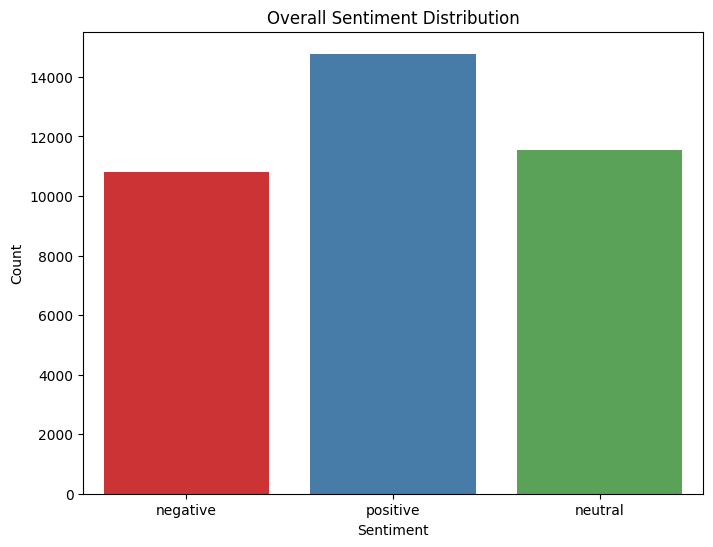

In [ ]:
#7b. Sentiment Distribution

plt.figure(figsize=(8,6))
sns.countplot(data=df, x='sentiment', palette='Set1')
plt.title("Overall Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [ ]:
#7c. Wordcloud (without stopwords)
all_text = ' '.join(df['clean_text_no_stopwords'].dropna().astype(str))
wordcloud = WordCloud(width=1200, height=600, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Wordcloud of Tweets (stopwords removed)")
plt.show()


In [ ]:
# 7d. Top Subword Tokens
from collections import Counter

all_tokens = [tok for sublist in df['subword_tokens'] for tok in eval(str(sublist))]
top_tokens = Counter(all_tokens).most_common(20)
tokens, counts = zip(*top_tokens)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(tokens), palette='magma')
plt.title("Top 20 Subword Tokens")
plt.xlabel("Frequency")
plt.ylabel("Subword Token")
plt.show()

/tmp/ipython-input-4182511597.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(tokens), palette='magma')


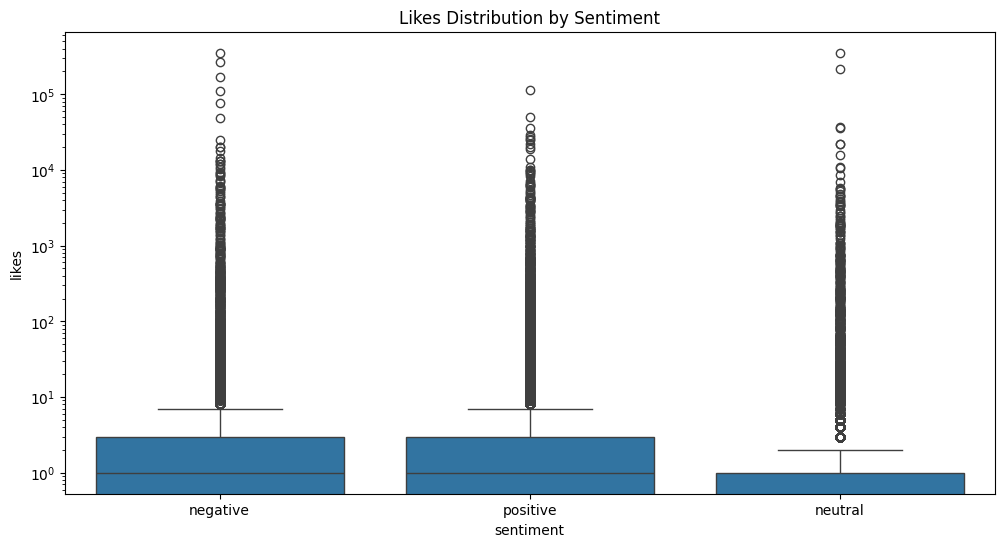

In [ ]:
#7e. Engagement vs Sentiment

plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='likes', data=df)
plt.yscale('log')
plt.title("Likes Distribution by Sentiment")
plt.show()

# Replies by sentiment
plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='replies', data=df)
plt.yscale('log')
plt.title("Replies Distribution by Sentiment")
plt.show()

# Reposts by sentiment
plt.figure(figsize=(12,6))
sns.boxplot(x='sentiment', y='reposts', data=df)
plt.yscale('log')
plt.title("Reposts Distribution by Sentiment")
plt.show()

/tmp/ipython-input-2556621451.py:12: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_2025['month_year'] = df_2025['time'].dt.to_period('M').astype(str)


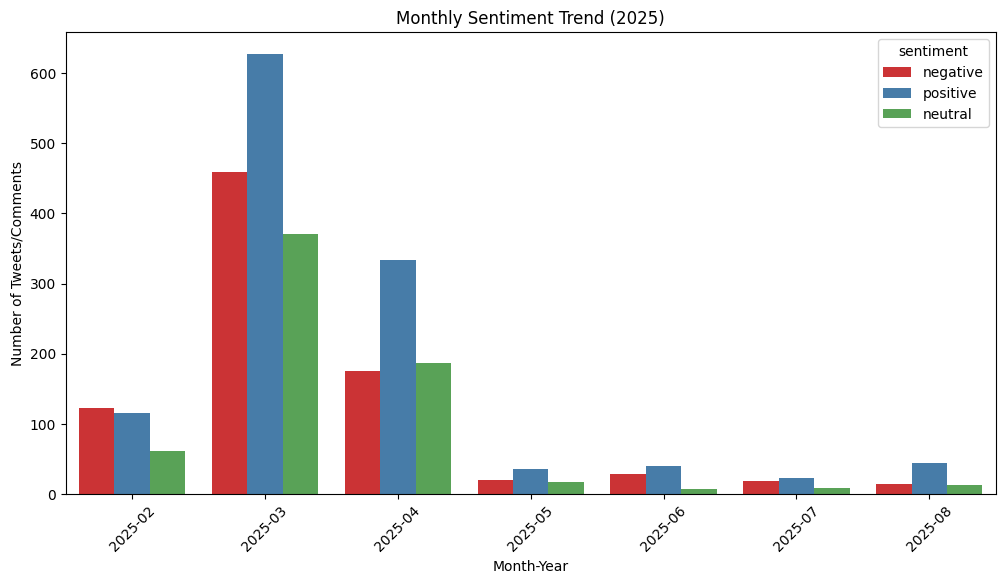

In [ ]:
#7f. Sentiment Over Time


# Ensure 'time' is datetime
df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)
df = df.dropna(subset=['time'])

# Filter 2025 only
df_2025 = df[df['time'].dt.year == 2025].copy()

# Create month-year column as string for plotting
df_2025['month_year'] = df_2025['time'].dt.to_period('M').astype(str)

months_sorted = sorted(df_2025['month_year'].unique())

plt.figure(figsize=(12,6))
sns.countplot(
    data=df_2025,
    x='month_year',
    hue='sentiment',
    palette='Set1',
    order=months_sorted   # enforce chronological order
)
plt.xticks(rotation=45)
plt.title("Monthly Sentiment Trend (2025)")
plt.xlabel("Month-Year")
plt.ylabel("Number of Tweets/Comments")
plt.show()

/tmp/ipython-input-3594882980.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(tags), palette='coolwarm')


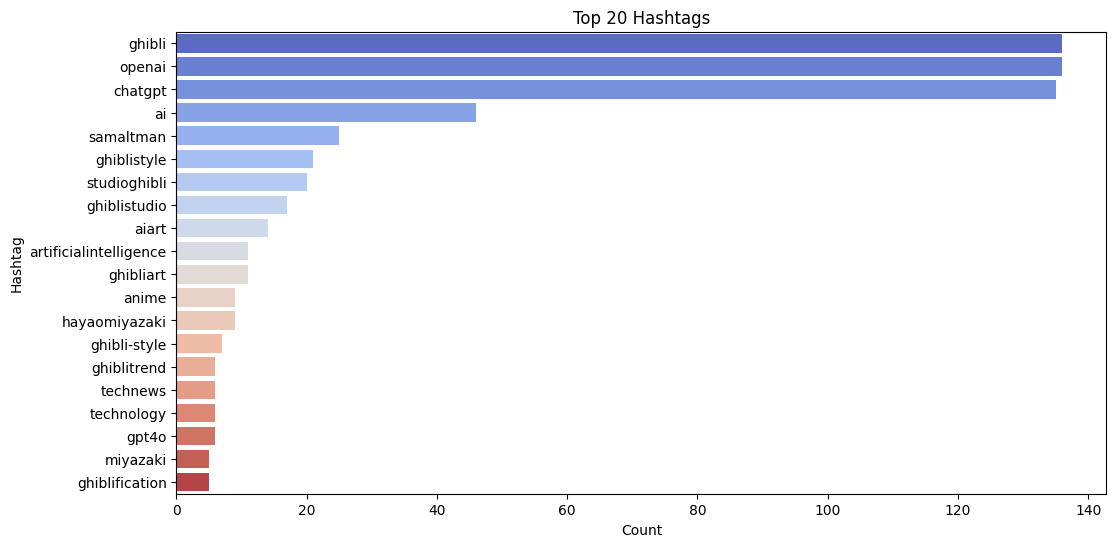

In [ ]:
#7g. Hashtag Analysis

def extract_hashtags(text):
    return [tag.strip("#") for tag in text.split() if tag.startswith("#")]

df['hashtags'] = df['translated_text'].astype(str).apply(extract_hashtags)
all_hashtags = [tag.lower() for sublist in df['hashtags'] for tag in sublist]
top_hashtags = Counter(all_hashtags).most_common(20)
tags, counts = zip(*top_hashtags)

plt.figure(figsize=(12,6))
sns.barplot(x=list(counts), y=list(tags), palette='coolwarm')
plt.title("Top 20 Hashtags")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.show()


PART 2: Full Colab Workflow for Fine-Tuning BERT, RoBERTa, DistilBERT

In [ ]:
!pip install --upgrade pyarrow
!pip install datasets
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load your preprocessed dataset
df = pd.read_csv('/content/drive/MyDrive/sentiment analysis/cleaned_ghibli_dataset_preprocessed.csv')

# Ensure no NaNs in clean_text
df['clean_text'] = df['clean_text'].fillna("").astype(str)

# Map sentiment to numeric labels
label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
df['label'] = df['sentiment'].map(label_map)

# Split data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['clean_text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels,
    test_size=0.1,
    stratify=train_labels,
    random_state=42
)

# Create Hugging Face Datasets
train_dataset = Dataset.from_dict({'text': train_texts, 'labels': train_labels})
val_dataset = Dataset.from_dict({'text': val_texts, 'labels': val_labels})
test_dataset = Dataset.from_dict({'text': test_texts, 'labels': test_labels})


In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"  # You can change to BERT/RoBERTa later
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/26728 [00:00<?, ? examples/s]

Map:   0%|          | 0/2970 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

In [ ]:
 from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1343010115.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: nnfiha2000 (nnfiha2000-jahangirnagar-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=5013, training_loss=0.31005284892283297, metrics={'train_runtime': 41746.5287, 'train_samples_per_second': 1.921, 'train_steps_per_second': 0.12, 'total_flos': 2655488829487104.0, 'train_loss': 0.31005284892283297, 'epoch': 3.0})

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
set_seed(42)

id2label = {0: "positive", 1: "neutral", 2: "negative"}
label2id = {v:k for k,v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=3, id2label=id2label, label2id=label2id
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,                 # more granular curves
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[]                      # avoid wandb auto-login
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_output = trainer.train()


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-440145573.py:37: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


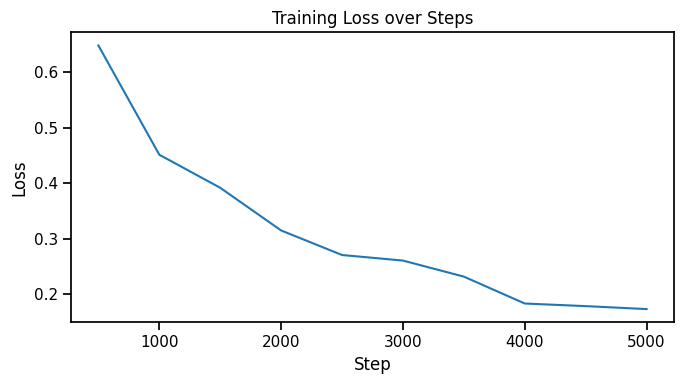

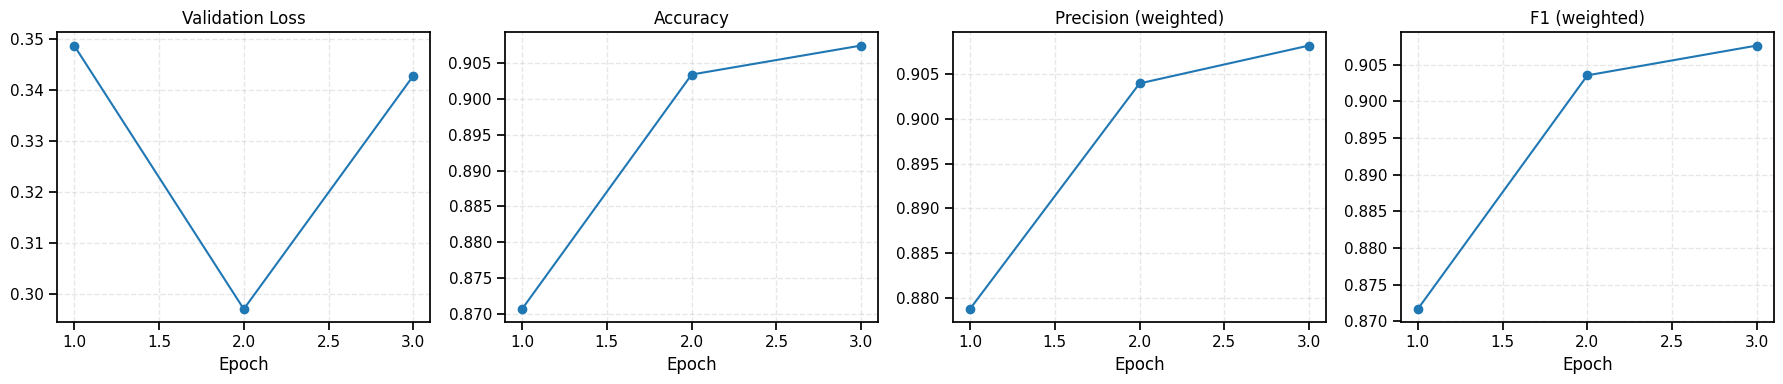

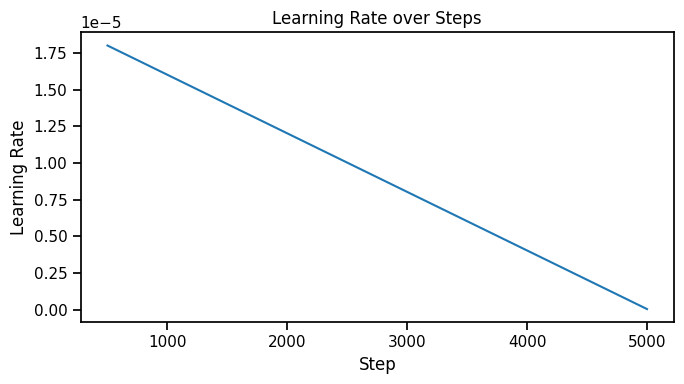

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


NameError: name 'id2label' is not defined

<Figure size 600x500 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import torch

sns.set_context("notebook")

# ---------- Collect logs into a DataFrame ----------
logs = pd.DataFrame(trainer.state.log_history)

# Training loss (steps) and Eval metrics (epochs)
train_loss_df = logs.loc[logs["loss"].notna(), ["step", "loss"]].rename(columns={"loss":"train_loss"})
eval_df = logs.loc[logs["eval_loss"].notna(), ["epoch", "eval_loss", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]]

# ---------- Plot: Training loss over steps ----------
plt.figure(figsize=(7,4))
plt.plot(train_loss_df["step"], train_loss_df["train_loss"])
plt.title("Training Loss over Steps")
plt.xlabel("Step"); plt.ylabel("Loss")
plt.tight_layout(); plt.show()

# ---------- Plot: Eval loss/metrics over epochs ----------
fig, axes = plt.subplots(1, 4, figsize=(18,4))
axes[0].plot(eval_df["epoch"], eval_df["eval_loss"], marker="o");      axes[0].set_title("Validation Loss")
axes[1].plot(eval_df["epoch"], eval_df["eval_accuracy"], marker="o");  axes[1].set_title("Accuracy")
axes[2].plot(eval_df["epoch"], eval_df["eval_precision"], marker="o"); axes[2].set_title("Precision (weighted)")
axes[3].plot(eval_df["epoch"], eval_df["eval_f1"], marker="o");        axes[3].set_title("F1 (weighted)")
for ax in axes: ax.set_xlabel("Epoch"); ax.grid(True, ls="--", alpha=.3)
plt.tight_layout(); plt.show()

# ---------- Plot: Learning rate over steps ----------
lr_logs = logs.loc[logs["learning_rate"].notna(), ["step", "learning_rate"]]
if not lr_logs.empty:
    plt.figure(figsize=(7,4))
    plt.plot(lr_logs["step"], lr_logs["learning_rate"])
    plt.title("Learning Rate over Steps")
    plt.xlabel("Step"); plt.ylabel("Learning Rate")
    plt.tight_layout(); plt.show()

# ---------- Predictions on test set ----------
preds_output = trainer.predict(test_dataset)
y_logits = preds_output.predictions
y_prob = torch.softmax(torch.tensor(y_logits), dim=1).numpy()
y_pred = y_prob.argmax(axis=1)
y_true = np.array(test_dataset["labels"])

# ---------- Confusion Matrix (kept from yours, polished) ----------
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in [0,1,2]],
            yticklabels=[id2label[i] for i in [0,1,2]])
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# ---------- Per-class Precision / Recall / F1 bar chart ----------
from sklearn.metrics import precision_recall_fscore_support
per_p, per_r, per_f1, support = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2], zero_division=0)
per_df = pd.DataFrame({
    "class": [id2label[i] for i in [0,1,2]],
    "precision": per_p,
    "recall": per_r,
    "f1": per_f1,
    "support": support
})
plt.figure(figsize=(8,4))
per_df.set_index("class")[["precision","recall","f1"]].plot(kind="bar")
plt.title("Per-class Metrics"); plt.ylim(0,1.05); plt.xlabel(""); plt.ylabel("Score")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()
display(per_df)

# ---------- ROC & PR Curves (one-vs-rest) ----------
classes = [0,1,2]
y_true_bin = label_binarize(y_true, classes=classes)

# ROC
plt.figure(figsize=(6,5))
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (OvR)"); plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.tight_layout(); plt.show()

# Precision-Recall
plt.figure(figsize=(6,5))
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{id2label[i]} (AP={ap:.3f})")
plt.title("Precision-Recall Curves (OvR)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
plt.tight_layout(); plt.show()

# ---------- Text examples: a few high-confidence mistakes ----------
inv_label_map = {0:"positive",1:"neutral",2:"negative"}
test_texts_list = test_dataset["text"] if "text" in test_dataset.column_names else df.loc[df.index.isin(test_dataset["__index_level_0__"]),"clean_text"].tolist()
probs_max = y_prob.max(axis=1)
wrong_idx = np.where(y_pred != y_true)[0]
# pick top 5 most confident wrong predictions
top_wrong = wrong_idx[np.argsort(probs_max[wrong_idx])[::-1][:5]]

print("\n=== High-confidence Misclassifications (top 5) ===")
for i in top_wrong:
    print(f"\nText: {test_texts_list[i][:240]}{'...' if len(test_texts_list[i])>240 else ''}")
    print(f"True: {inv_label_map[y_true[i]]} | Pred: {inv_label_map[y_pred[i]]} | p(pred)={probs_max[i]:.3f}")

# ---------- Full classification report ----------
print("\n=== Classification Report ===")
print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in [0,1,2]], digits=4))


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


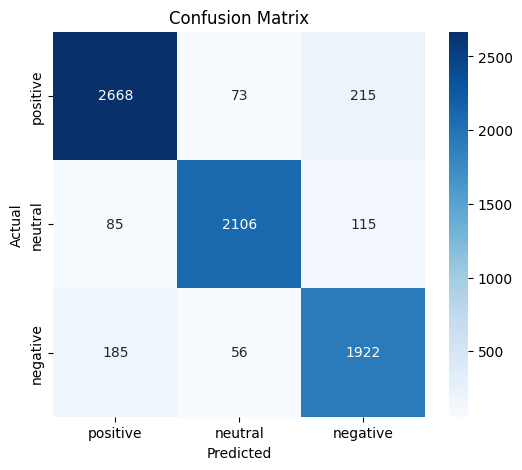

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

preds_output = trainer.predict(test_dataset)
y_pred = preds_output.predictions.argmax(-1)
y_true = test_dataset['labels']

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Map:   0%|          | 0/26728 [00:00<?, ? examples/s]

Map:   0%|          | 0/2970 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-4125985388.py:165: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


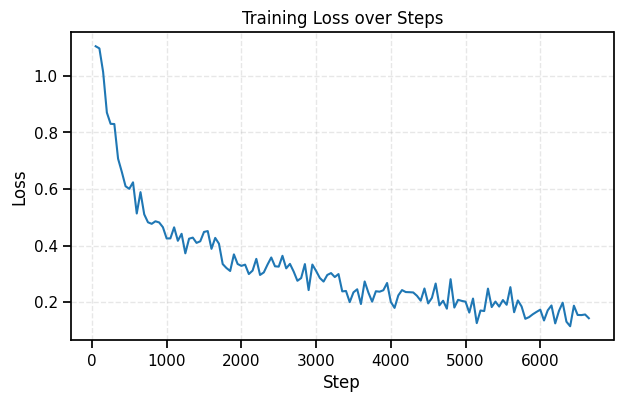

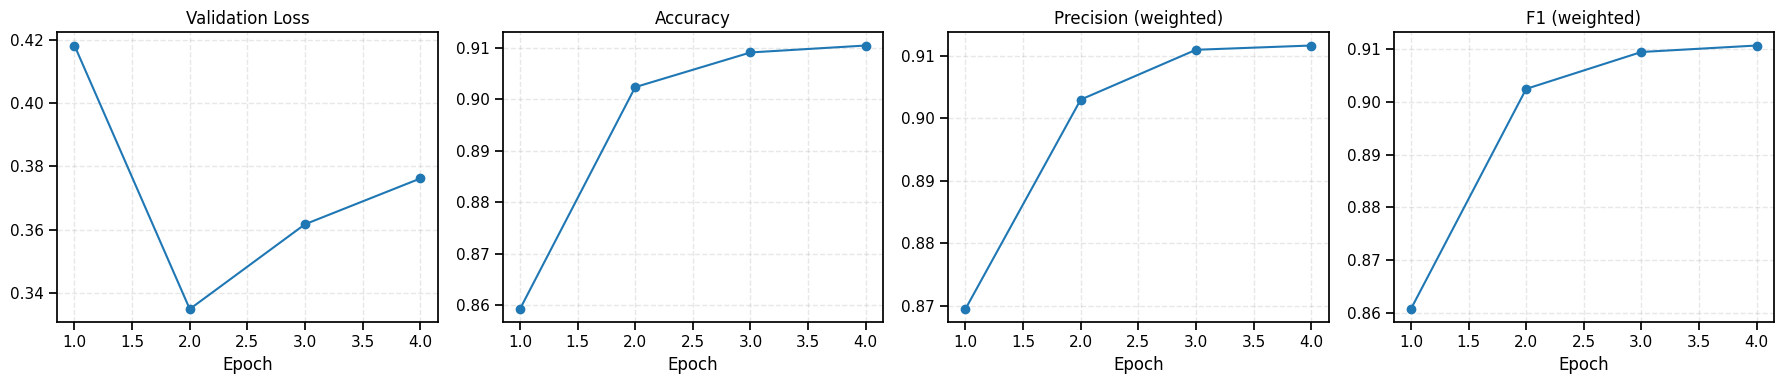

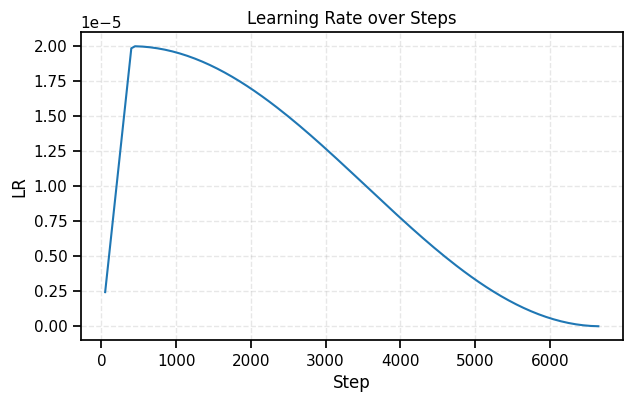

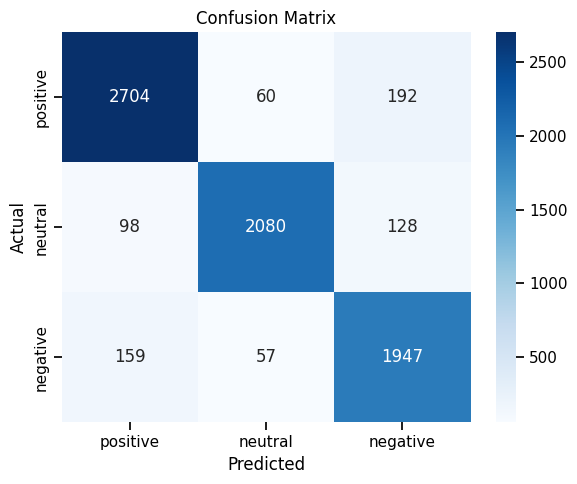

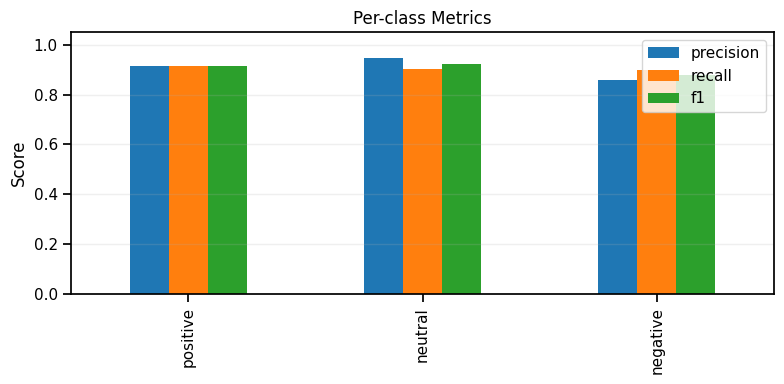

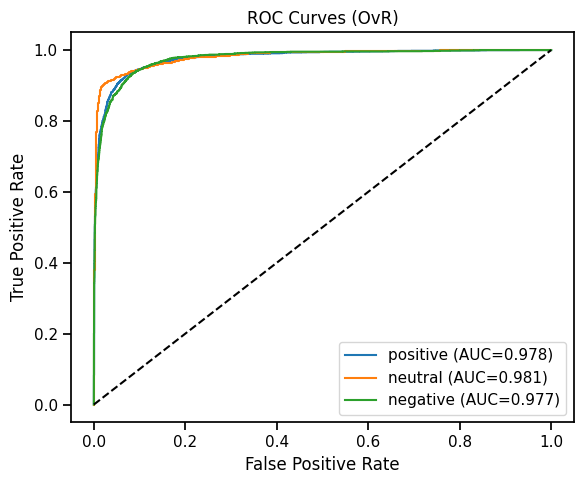

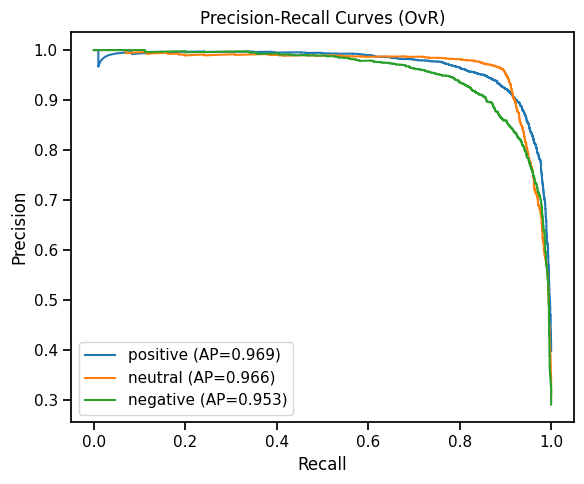

              precision    recall  f1-score   support

    positive     0.9132    0.9147    0.9140      2956
     neutral     0.9467    0.9020    0.9238      2306
    negative     0.8588    0.9001    0.8790      2163

    accuracy                         0.9065      7425
   macro avg     0.9063    0.9056    0.9056      7425
weighted avg     0.9078    0.9065    0.9068      7425



In [ ]:
# ===========================
# THESIS-GRADE SENTIMENT PIPE
# ===========================
# Colab Pro friendly: fp16, robust logging, CV curves, wordclouds, per-source metrics

# !pip install --upgrade pyarrow
# !pip install -U datasets transformers accelerate evaluate scikit-learn matplotlib seaborn wordcloud

import os, json, random, math, itertools
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback, set_seed
)

# ------------ PATHS / SETTINGS ------------
DATA_CSV  = "/content/drive/MyDrive/sentiment analysis/cleaned_ghibli_dataset_preprocessed.csv"
SAVE_DIR  = "/content/drive/MyDrive/sentiment analysis/thesis_outputs"
MODEL_NAME = "roberta-base"   # alternatives: "bert-base-uncased", "distilbert-base-uncased"
MAX_LEN    = 128              # you can try 256 if YouTube comments are longer (watch VRAM)
EPOCHS     = 4                # let early stopping pick the best; Colab Pro can handle
LR         = 2e-5
TRAIN_BS   = 16               # try 32 on A100; drop to 8 if OOM
EVAL_BS    = 32
SEED       = 42
KFOLDS     = 5

os.makedirs(SAVE_DIR, exist_ok=True)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ------------ LOAD DATA ------------
df = pd.read_csv(DATA_CSV)

# Expected columns: 'clean_text', 'sentiment'
# Optional: 'source' in {"twitter","youtube"} for platform-wise analysis
assert "clean_text" in df.columns and "sentiment" in df.columns, "CSV must have 'clean_text' and 'sentiment' columns"
df["clean_text"] = df["clean_text"].fillna("").astype(str)

label_map = {"positive":0, "neutral":1, "negative":2}
df["label"] = df["sentiment"].map(label_map).astype(int)

# ------------ STRATIFIED SPLIT (tries to preserve platform balance if 'source' exists) ------------
if "source" in df.columns:
    # make a stratification key combining label and source to better balance both
    strat_key = df["label"].astype(str) + "_" + df["source"].astype(str)
else:
    strat_key = df["label"]

train_idx, test_idx = train_test_split(
    np.arange(len(df)), test_size=0.20, random_state=SEED, stratify=strat_key
)
# Further split train into train/val
train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

if "source" in train_df.columns:
    strat_key_tv = train_df["label"].astype(str) + "_" + train_df["source"].astype(str)
else:
    strat_key_tv = train_df["label"]

train_idx2, val_idx2 = train_test_split(
    np.arange(len(train_df)), test_size=0.10, random_state=SEED, stratify=strat_key_tv
)

train_split = train_df.iloc[train_idx2].reset_index(drop=True)
val_split   = train_df.iloc[val_idx2].reset_index(drop=True)

# ------------ TOKENIZER ------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tok(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=MAX_LEN)

# ------------ DATASETS ------------
train_ds = Dataset.from_dict({"text": train_split["clean_text"].tolist(), "labels": train_split["label"].tolist()}).map(tok, batched=True)
val_ds   = Dataset.from_dict({"text": val_split["clean_text"].tolist(),   "labels": val_split["label"].tolist()}).map(tok, batched=True)
test_ds  = Dataset.from_dict({"text": test_df["clean_text"].tolist(),     "labels": test_df["label"].tolist()}).map(tok, batched=True)

# Keep raw test texts for error analysis
test_texts = test_df["clean_text"].tolist()
test_sources = test_df["source"].tolist() if "source" in test_df.columns else None

# ------------ OPTIONAL: CLASS WEIGHTS (handles imbalance) ------------
class_counts = train_split["label"].value_counts().sort_index().values
class_weights = (1.0 / (class_counts + 1e-9))
class_weights = class_weights / class_weights.sum() * len(class_counts)  # normalized around num_classes
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

# Custom Trainer to inject weighted loss
from transformers.trainer import Trainer as HFTrainer
import torch.nn.functional as F

# Custom WeightedTrainer to inject class-weighted loss
class WeightedTrainer(HFTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        if labels is not None:
            loss = F.cross_entropy(logits, labels, weight=class_weights_t.to(model.device))  # Use class weights here
        else:
            loss = outputs["loss"] if "loss" in outputs else None
        return (loss, outputs) if return_outputs else loss


# ------------ MODEL ------------
id2label = {0:"positive",1:"neutral",2:"negative"}
label2id = {v:k for k,v in id2label.items()}
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
)

# ------------ METRICS ------------
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# ------------ TRAINING ARGS ------------
args = TrainingArguments(
    output_dir=os.path.join(SAVE_DIR, "results_main"),
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=LR,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    fp16=True,                        # Colab Pro GPUs support this
    gradient_accumulation_steps=1,    # bump if you want larger effective batch
    warmup_ratio=0.06,                # smoother start
    lr_scheduler_type="cosine",
    logging_dir=os.path.join(SAVE_DIR, "logs"),
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[]                      # disable wandb auto-login
)


# ------------ Recreate the Trainer with Weighted Loss ------------

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

train_output = trainer.train()



# ------------ LOGS & CURVES ------------
sns.set_context("notebook")
logs = pd.DataFrame(trainer.state.log_history)

def savefig(name):
    plt.savefig(os.path.join(SAVE_DIR, f"{name}.png"), dpi=240, bbox_inches="tight")

# Train loss over steps
tl = logs.loc[logs["loss"].notna(), ["step","loss"]].rename(columns={"loss":"train_loss"})
plt.figure(figsize=(7,4)); plt.plot(tl["step"], tl["train_loss"])
plt.title("Training Loss over Steps"); plt.xlabel("Step"); plt.ylabel("Loss"); plt.grid(True, ls="--", alpha=.3)
savefig("train_loss_steps"); plt.show()

# Eval curves over epochs
ev = logs.loc[logs["eval_loss"].notna(), ["epoch","eval_loss","eval_accuracy","eval_precision","eval_recall","eval_f1"]]
fig, axes = plt.subplots(1,4, figsize=(18,4))
axes[0].plot(ev["epoch"], ev["eval_loss"], marker="o"); axes[0].set_title("Validation Loss")
axes[1].plot(ev["epoch"], ev["eval_accuracy"], marker="o"); axes[1].set_title("Accuracy")
axes[2].plot(ev["epoch"], ev["eval_precision"], marker="o"); axes[2].set_title("Precision (weighted)")
axes[3].plot(ev["epoch"], ev["eval_f1"], marker="o"); axes[3].set_title("F1 (weighted)")
for ax in axes: ax.set_xlabel("Epoch"); ax.grid(True, ls="--", alpha=.3)
savefig("eval_curves_epochs"); plt.tight_layout(); plt.show()

# Learning rate over steps
lr = logs.loc[logs["learning_rate"].notna(), ["step","learning_rate"]]
if not lr.empty:
    plt.figure(figsize=(7,4)); plt.plot(lr["step"], lr["learning_rate"])
    plt.title("Learning Rate over Steps"); plt.xlabel("Step"); plt.ylabel("LR"); plt.grid(True, ls="--", alpha=.3)
    savefig("learning_rate_steps"); plt.show()

# ------------ TEST EVAL & PLOTS ------------
preds_output = trainer.predict(test_ds)
y_logits = preds_output.predictions
y_prob = torch.softmax(torch.tensor(y_logits), dim=1).numpy()
y_pred = y_prob.argmax(1)
y_true = np.array(test_ds["labels"])

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in [0,1,2]],
            yticklabels=[id2label[i] for i in [0,1,2]])
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
savefig("confusion_matrix"); plt.tight_layout(); plt.show()

# Per-class bars
p_c, r_c, f1_c, sup_c = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2], zero_division=0)
per_df = pd.DataFrame({"class":[id2label[i] for i in [0,1,2]], "precision":p_c, "recall":r_c, "f1":f1_c, "support":sup_c})
per_df.set_index("class")[["precision","recall","f1"]].plot(kind="bar", figsize=(8,4))
plt.title("Per-class Metrics"); plt.ylim(0,1.05); plt.xlabel(""); plt.ylabel("Score"); plt.grid(axis="y", alpha=.2)
savefig("per_class_bars"); plt.tight_layout(); plt.show()
per_df.to_csv(os.path.join(SAVE_DIR, "per_class_metrics.csv"), index=False)

# ROC/PR (one-vs-rest)
classes = [0,1,2]
y_true_bin = label_binarize(y_true, classes=classes)

plt.figure(figsize=(6,5))
for i in classes:
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--"); plt.title("ROC Curves (OvR)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
savefig("roc_ovr"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
for i in classes:
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{id2label[i]} (AP={ap:.3f})")
plt.title("Precision-Recall Curves (OvR)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
savefig("pr_ovr"); plt.tight_layout(); plt.show()

# Classification report (text + save)
report = classification_report(y_true, y_pred, target_names=[id2label[i] for i in classes], digits=4, zero_division=0)
print(report)
with open(os.path.join(SAVE_DIR, "classification_report.txt"), "w") as f:
    f.write(report)

# ------------ PER-SOURCE METRICS (Twitter vs YouTube) ------------
if test_sources is not None:
    src_arr = np.array(test_sources)
    for src in sorted(pd.unique(src_arr)):
        idx = np.where(src_arr == src)[0]
        if len(idx) == 0: continue
        yt, yp = y_true[idx], y_pred[idx]
        p, r, f1, _ = precision_recall_fscore_support(yt, yp, average="weighted", zero_division=0)
        acc = accuracy_score(yt, yp)
        print(f"\n=== {src.upper()} TEST ===")
        print(f"acc={acc:.4f}  p={p:.4f}  r={r:.4f}  f1={f1:.4f}")
        with open(os.path.join(SAVE_DIR, f"report_{src}.txt"), "w") as f:
            f.write(classification_report(yt, yp, target_names=[id2label[i] for i in classes], digits=4, zero_division=0))





Running K-Fold Cross-Validation ...

=== Fold 1 ===


Map:   0%|          | 0/29698 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1926952763.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FoldTrainer.__init__`. Use `processing_class` instead.
  trainer = FoldTrainer(



=== Fold 2 ===


Map:   0%|          | 0/29698 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1926952763.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FoldTrainer.__init__`. Use `processing_class` instead.
  trainer = FoldTrainer(



=== Fold 3 ===


Map:   0%|          | 0/29698 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1926952763.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FoldTrainer.__init__`. Use `processing_class` instead.
  trainer = FoldTrainer(



=== Fold 4 ===


Map:   0%|          | 0/29699 [00:00<?, ? examples/s]

Map:   0%|          | 0/7424 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1926952763.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FoldTrainer.__init__`. Use `processing_class` instead.
  trainer = FoldTrainer(



=== Fold 5 ===


Map:   0%|          | 0/29699 [00:00<?, ? examples/s]

Map:   0%|          | 0/7424 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1926952763.py:68: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FoldTrainer.__init__`. Use `processing_class` instead.
  trainer = FoldTrainer(



K-Fold CV Results (mean ± std):
- accuracy: 0.9135 ± 0.0030
- precision: 0.9147 ± 0.0028
- recall: 0.9135 ± 0.0030
- f1: 0.9138 ± 0.0030


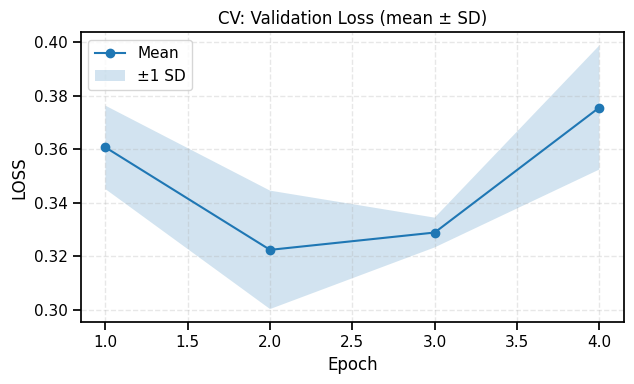

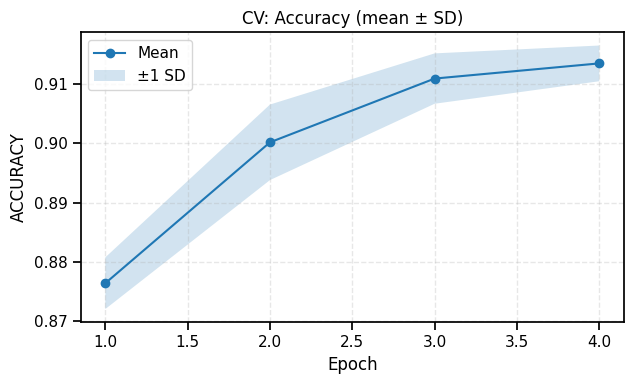

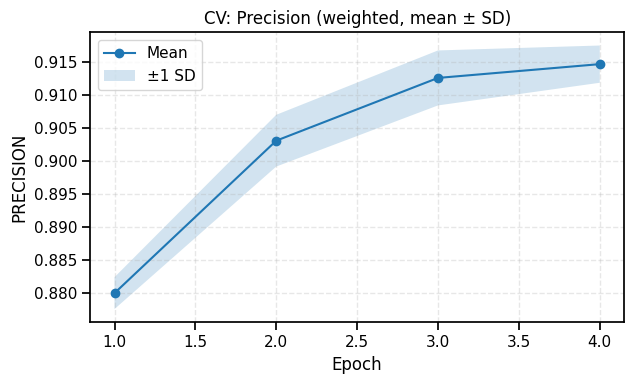

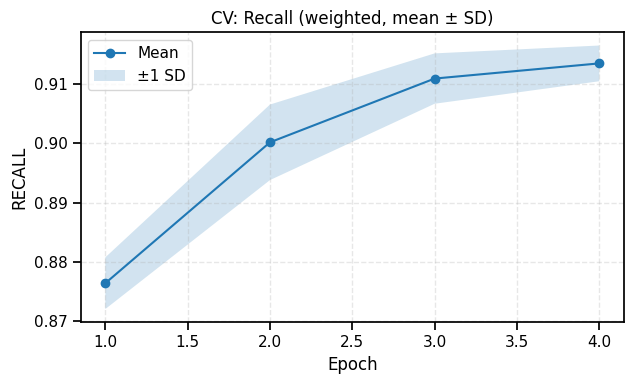

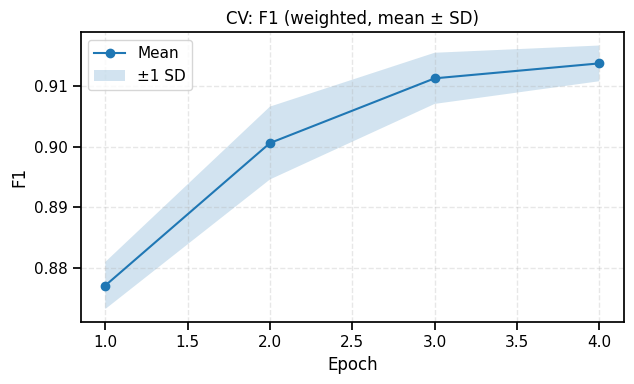

In [ ]:
# ---------------- K-FOLD CV ----------------
print("\nRunning K-Fold Cross-Validation ...")

# Prepare all texts and labels
texts_all = df["clean_text"].astype(str).tolist()
labels_all = df["label"].astype(int).tolist()

# Function to run a single fold
def run_fold(train_idx, val_idx, fold_id):
    """
    Train and evaluate a single fold of K-Fold CV.
    Returns the evaluation logs per epoch and final metrics for the fold.
    """
    # Create train and validation datasets for this fold
    tr_ds = Dataset.from_dict({
        "text": [texts_all[i] for i in train_idx],
        "labels": [labels_all[i] for i in train_idx]
    }).map(tok, batched=True)

    va_ds = Dataset.from_dict({
        "text": [texts_all[i] for i in val_idx],
        "labels": [labels_all[i] for i in val_idx]
    }).map(tok, batched=True)

    # Initialize a fresh model for this fold
    fold_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        id2label=id2label,
        label2id=label2id
    )

    # Recompute class weights for this fold (to handle imbalance)
    fold_counts = np.bincount([labels_all[i] for i in train_idx], minlength=3)
    fold_cw = (1.0 / (fold_counts + 1e-9))      # avoid divide by zero
    fold_cw = fold_cw / fold_cw.sum() * 3       # normalize around num_classes
    fold_cw_t = torch.tensor(fold_cw, dtype=torch.float)

    # Custom trainer using weighted loss
    class FoldTrainer(WeightedTrainer):
        pass

    # Fold-specific metrics function
    def fold_metrics(pred):
        labs = pred.label_ids
        preds = pred.predictions.argmax(-1)
        p, r, f1, _ = precision_recall_fscore_support(labs, preds, average="weighted", zero_division=0)
        acc = accuracy_score(labs, preds)
        return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

    # Training arguments for this fold
    fold_args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR, f"results_cv/fold{fold_id}"),
        eval_strategy="epoch",
        save_strategy="no",
        learning_rate=LR,
        per_device_train_batch_size=TRAIN_BS,
        per_device_eval_batch_size=EVAL_BS,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        fp16=True,
        logging_strategy="steps",
        logging_steps=50,
        report_to=[]
    )

    # Initialize the trainer
    trainer = FoldTrainer(
        model=fold_model,
        args=fold_args,
        train_dataset=tr_ds,
        eval_dataset=va_ds,
        tokenizer=tokenizer,
        compute_metrics=fold_metrics
    )

    # Attach class weights for weighted loss
    trainer.class_weights = fold_cw_t

    # Train the fold
    trainer.train()

    # Collect evaluation logs
    logs = pd.DataFrame(trainer.state.log_history)
    eval_logs = logs.loc[logs["eval_loss"].notna(), ["epoch", "eval_loss", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]].copy()
    eval_logs["fold"] = fold_id

    # Take the last epoch as the fold's final metrics
    final_metrics = eval_logs.sort_values("epoch").iloc[-1].to_dict()
    return eval_logs, final_metrics

# Stratified K-Fold splitting
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)
all_eval_logs, fold_finals = [], []

for f, (train_idx, val_idx) in enumerate(skf.split(texts_all, labels_all), start=1):
    print(f"\n=== Fold {f} ===")
    ev_logs, fin_metrics = run_fold(train_idx, val_idx, f)
    all_eval_logs.append(ev_logs)
    fold_finals.append(fin_metrics)

# Combine all fold logs
cv_curves = pd.concat(all_eval_logs, ignore_index=True)
cv_summary = pd.DataFrame(fold_finals)[["fold", "eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]].sort_values("fold")
cv_summary.to_csv(os.path.join(SAVE_DIR, "cv_summary.csv"), index=False)

# Print mean ± std metrics across folds
print("\nK-Fold CV Results (mean ± std):")
for metric in ["eval_accuracy", "eval_precision", "eval_recall", "eval_f1"]:
    print(f"- {metric[5:]}: {cv_summary[metric].mean():.4f} ± {cv_summary[metric].std():.4f}")

# ---------------- Helper: Plot CV Curves ----------------
def cv_plot(key, title, fname):
    grp = cv_curves.groupby("epoch")[key]
    mean, std = grp.mean(), grp.std()
    plt.figure(figsize=(6.5, 4))
    plt.plot(mean.index, mean.values, marker="o", label="Mean")
    plt.fill_between(mean.index, mean - std, mean + std, alpha=0.2, label="±1 SD")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(key.replace("eval_", "").upper())
    plt.grid(True, ls="--", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, f"{fname}.png"))
    plt.show()

# Plot curves for all metrics
cv_plot("eval_loss", "CV: Validation Loss (mean ± SD)", "cv_val_loss")
cv_plot("eval_accuracy", "CV: Accuracy (mean ± SD)", "cv_accuracy")
cv_plot("eval_precision", "CV: Precision (weighted, mean ± SD)", "cv_precision")
cv_plot("eval_recall", "CV: Recall (weighted, mean ± SD)", "cv_recall")
cv_plot("eval_f1", "CV: F1 (weighted, mean ± SD)", "cv_f1")


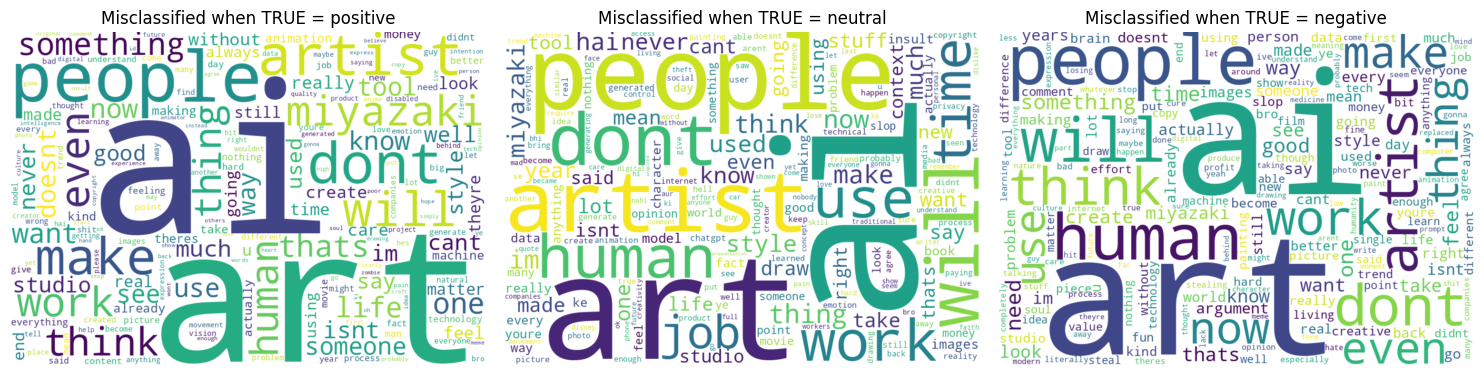


✅ Done. Figures and reports saved to: /content/drive/MyDrive/sentiment analysis/thesis_outputs


In [ ]:
# ------------ ERROR WORDCLOUDS (true-class buckets) ------------
stop = set(STOPWORDS) | {"rt","http","https","co","amp","ghibli","openai","image","video"}
mis_by_true = {c: [] for c in classes}
for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt != yp:
        mis_by_true[yt].append(test_texts[i])

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for idx, c in enumerate(classes):
    blob = " ".join(mis_by_true[c]) if mis_by_true[c] else "no errors"
    wc = WordCloud(width=1000, height=700, background_color="white",
                   stopwords=stop, collocations=False, max_words=200).generate(blob)
    axes[idx].imshow(wc, interpolation="bilinear"); axes[idx].axis("off")
    axes[idx].set_title(f"Misclassified when TRUE = {id2label[c]}")
savefig("wordcloud_true_class"); plt.tight_layout(); plt.show()

# ------------ SAVE KEY ARTIFACTS ------------

trainer.model.save_pretrained(os.path.join(SAVE_DIR, "best_model"))
tokenizer.save_pretrained(os.path.join(SAVE_DIR, "best_model"))

# Fix for best_metric
if hasattr(trainer.state, "best_metric"):
    best_metric = trainer.state.best_metric
    if isinstance(best_metric, dict):
        final_eval = {k: float(v) for k, v in best_metric.items()}
    else:  # float case
        final_eval = {"f1": float(best_metric)}
else:
    final_eval = {}

with open(os.path.join(SAVE_DIR, "train_eval_summary.json"), "w") as f:
    json.dump({
        "final_eval": final_eval,
        "class_weights": class_weights.tolist(),
        "model_name": MODEL_NAME,
        "max_len": MAX_LEN
    }, f, indent=2)

print("\n✅ Done. Figures and reports saved to:", SAVE_DIR)




=== Fold 1 ===


Map:   0%|          | 0/29698 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2864623137.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(model=fold_model, args=args,



=== Fold 2 ===


Map:   0%|          | 0/29698 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2864623137.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(model=fold_model, args=args,



=== Fold 3 ===


Map:   0%|          | 0/29698 [00:00<?, ? examples/s]

Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2864623137.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(model=fold_model, args=args,



=== Fold 4 ===


Map:   0%|          | 0/29699 [00:00<?, ? examples/s]

Map:   0%|          | 0/7424 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2864623137.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(model=fold_model, args=args,



=== Fold 5 ===


Map:   0%|          | 0/29699 [00:00<?, ? examples/s]

Map:   0%|          | 0/7424 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2864623137.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(model=fold_model, args=args,


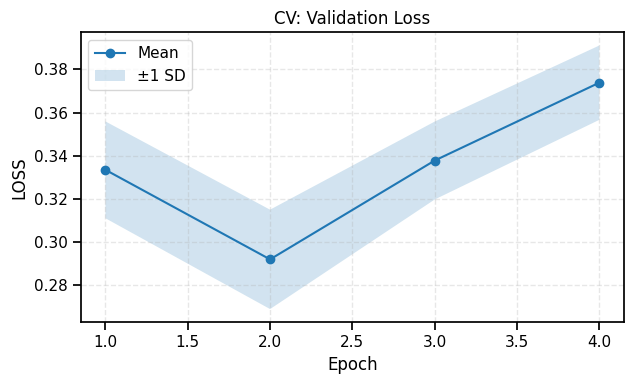

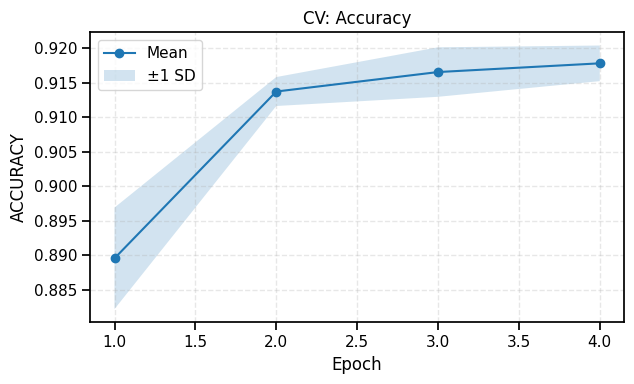

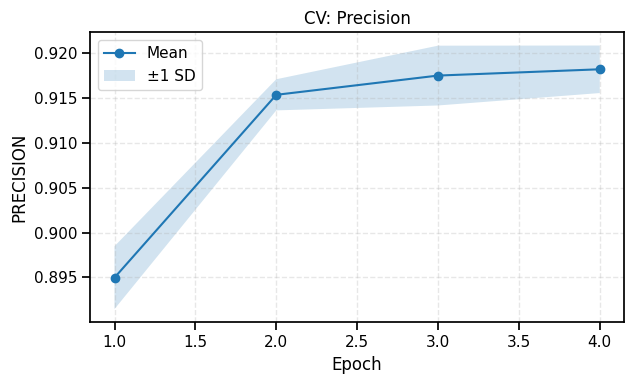

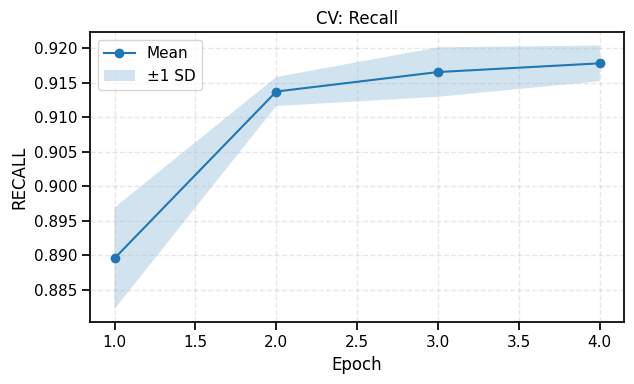

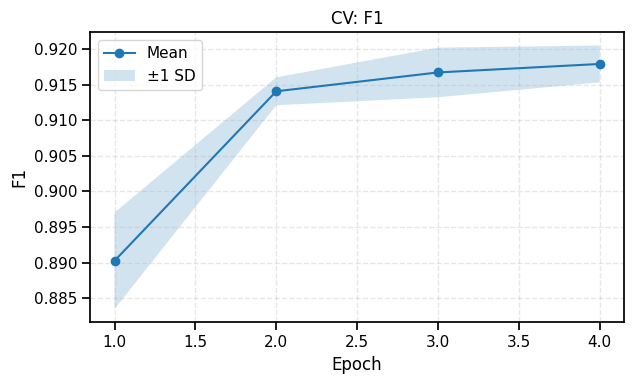

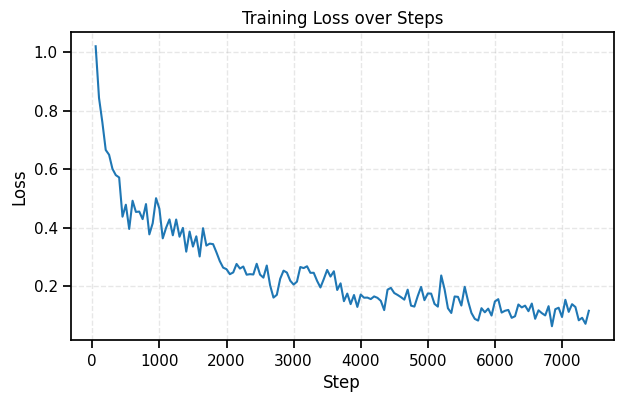

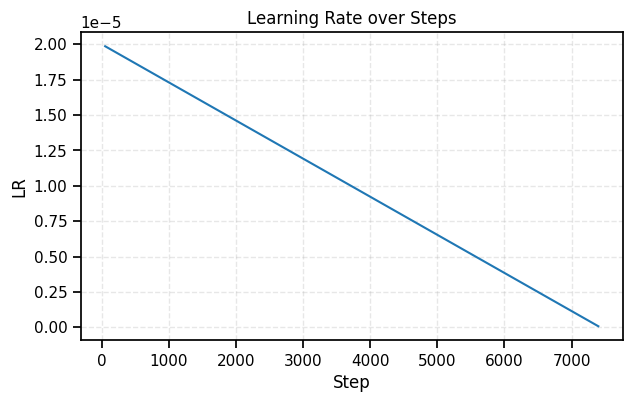

Map:   0%|          | 0/37123 [00:00<?, ? examples/s]

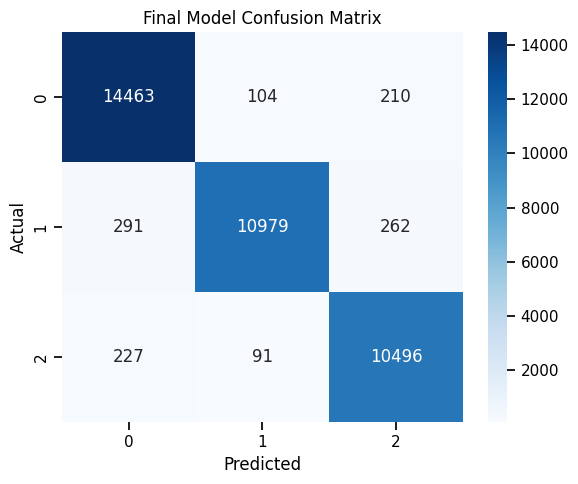

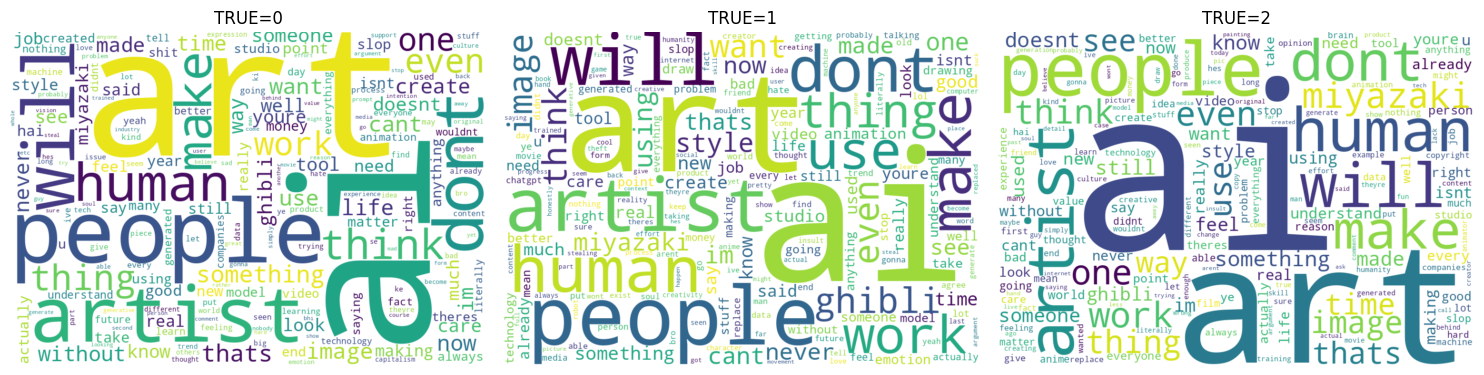


✅ Final Model Performance on Full Dataset:
- Accuracy : 0.9681
- Precision: 0.9683
- Recall   : 0.9681
- F1 Score : 0.9681


Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

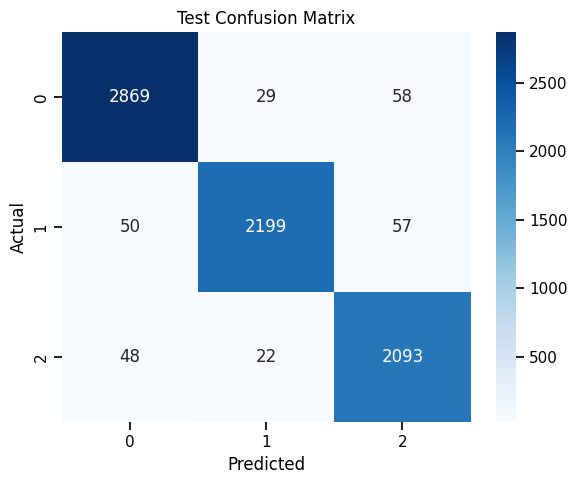

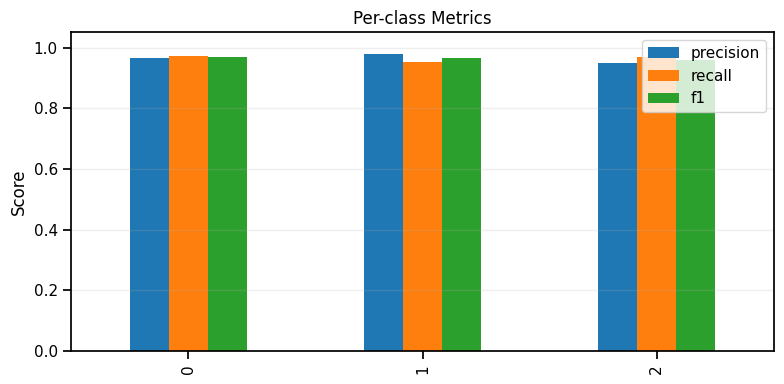

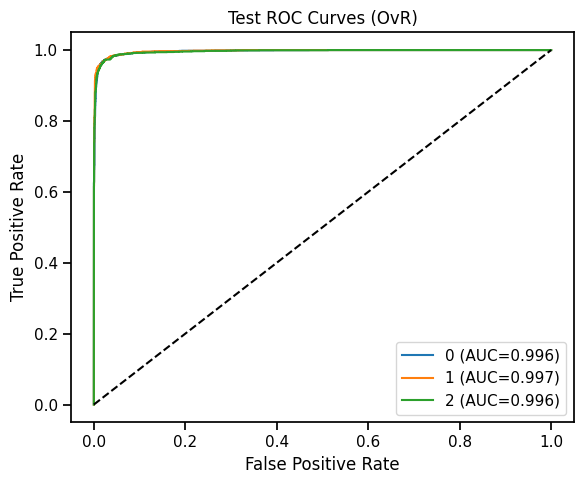

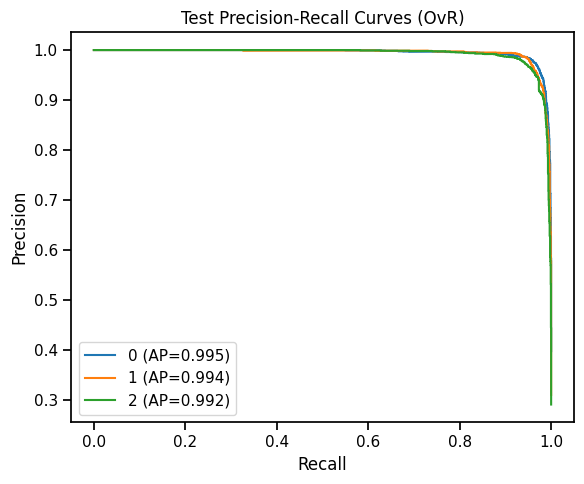

              precision    recall  f1-score   support

           0     0.9670    0.9706    0.9688      2956
           1     0.9773    0.9536    0.9653      2306
           2     0.9479    0.9676    0.9577      2163

    accuracy                         0.9644      7425
   macro avg     0.9641    0.9639    0.9639      7425
weighted avg     0.9646    0.9644    0.9645      7425



In [ ]:
# ------------------- SETUP -------------------
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from wordcloud import WordCloud, STOPWORDS

# ------------------- CONSTANTS -------------------
MODEL_NAME = "bert-base-uncased"  # or your model
SAVE_DIR = "results_bert"
os.makedirs(SAVE_DIR, exist_ok=True)
SEED = 42
KFOLDS = 5
EPOCHS = 4
TRAIN_BS, EVAL_BS = 16, 32
LR = 2e-5
MAX_LEN = 128

# ------------------- DATA -------------------
texts_all = df["clean_text"].astype(str).tolist()
labels_all = df["label"].astype(int).tolist()
classes = list(set(labels_all))
id2label = {i: str(i) for i in classes}
label2id = {v: k for k, v in id2label.items()}

# Optional test sources for per-source metrics
# test_sources = df_test["source"].tolist()  # example: Twitter, YouTube

# ------------------- TOKENIZER -------------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tok(batch): return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

# ------------------- CUSTOM TRAINER (weighted) -------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs ):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        if hasattr(self, "class_weights"):
            loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
            loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        else:
            loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

# ------------------- HELPER -------------------
sns.set_context("notebook")
def savefig(name): plt.savefig(os.path.join(SAVE_DIR, f"{name}.png"), dpi=240, bbox_inches="tight")

# ------------------- K-FOLD CROSS-VALIDATION -------------------
skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)
all_eval_logs, fold_finals = [], []

def run_fold(train_idx, val_idx, fold_id):
    tr_ds = Dataset.from_dict({"text":[texts_all[i] for i in train_idx],
                               "labels":[labels_all[i] for i in train_idx]}).map(tok, batched=True)
    va_ds = Dataset.from_dict({"text":[texts_all[i] for i in val_idx],
                               "labels":[labels_all[i] for i in val_idx]}).map(tok, batched=True)

    fold_model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(classes), id2label=id2label, label2id=label2id
    )

    counts = np.bincount([labels_all[i] for i in train_idx], minlength=len(classes))
    cw = (1.0 / (counts + 1e-9))
    cw = cw / cw.sum() * len(classes)
    cw_t = torch.tensor(cw, dtype=torch.float)

    def metrics(pred):
        labs = pred.label_ids
        preds = pred.predictions.argmax(-1)
        p,r,f1,_ = precision_recall_fscore_support(labs, preds, average="weighted", zero_division=0)
        acc = accuracy_score(labs, preds)
        return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

    args = TrainingArguments(
        output_dir=os.path.join(SAVE_DIR,f"fold{fold_id}"),
        eval_strategy="epoch", save_strategy="no",
        learning_rate=LR, per_device_train_batch_size=TRAIN_BS,
        per_device_eval_batch_size=EVAL_BS, num_train_epochs=EPOCHS,
        weight_decay=0.01, fp16=True, logging_strategy="steps", logging_steps=50, report_to=[]
    )

    trainer = WeightedTrainer(model=fold_model, args=args,
                              train_dataset=tr_ds, eval_dataset=va_ds,
                              tokenizer=tokenizer, compute_metrics=metrics)
    trainer.class_weights = cw_t
    trainer.train()

    logs = pd.DataFrame(trainer.state.log_history)
    eval_logs = logs.loc[logs["eval_loss"].notna(), ["epoch","eval_loss","eval_accuracy","eval_precision","eval_recall","eval_f1"]]
    eval_logs["fold"] = fold_id
    final_metrics = eval_logs.sort_values("epoch").iloc[-1].to_dict()
    return eval_logs, final_metrics, logs, trainer

# Run K-Fold
all_logs_steps, all_fold_metrics, trainer_list = [], [], []
for f, (train_idx, val_idx) in enumerate(skf.split(texts_all, labels_all), start=1):
    print(f"\n=== Fold {f} ===")
    ev_logs, fin_metrics, logs_steps, trainer_f = run_fold(train_idx, val_idx, f)
    all_eval_logs.append(ev_logs)
    fold_finals.append(fin_metrics)
    all_logs_steps.append(logs_steps)
    trainer_list.append(trainer_f)

cv_curves = pd.concat(all_eval_logs, ignore_index=True)
cv_summary = pd.DataFrame(fold_finals)[["fold","eval_accuracy","eval_precision","eval_recall","eval_f1"]].sort_values("fold")
cv_summary.to_csv(os.path.join(SAVE_DIR,"cv_summary.csv"), index=False)

# ------------------- CV & TRAIN PLOTS -------------------
def cv_plot(key, title, fname):
    grp = cv_curves.groupby("epoch")[key]
    mean, std = grp.mean(), grp.std()
    plt.figure(figsize=(6.5,4))
    plt.plot(mean.index, mean.values, marker="o", label="Mean")
    plt.fill_between(mean.index, mean-std, mean+std, alpha=0.2, label="±1 SD")
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(key.replace("eval_","").upper())
    plt.grid(True, ls="--", alpha=0.3); plt.legend(); plt.tight_layout(); savefig(fname); plt.show()

for k, t, f in [("eval_loss","CV: Validation Loss","cv_val_loss"),
                 ("eval_accuracy","CV: Accuracy","cv_accuracy"),
                 ("eval_precision","CV: Precision","cv_precision"),
                 ("eval_recall","CV: Recall","cv_recall"),
                 ("eval_f1","CV: F1","cv_f1")]:
    cv_plot(k,t,f)

# Training loss & LR (last fold)
logs = all_logs_steps[-1]
tl = logs.loc[logs["loss"].notna(), ["step","loss"]].rename(columns={"loss":"train_loss"})
plt.figure(figsize=(7,4)); plt.plot(tl["step"], tl["train_loss"])
plt.title("Training Loss over Steps"); plt.xlabel("Step"); plt.ylabel("Loss"); plt.grid(True, ls="--", alpha=.3)
savefig("train_loss_steps"); plt.show()

lr = logs.loc[logs["learning_rate"].notna(), ["step","learning_rate"]]
if not lr.empty:
    plt.figure(figsize=(7,4)); plt.plot(lr["step"], lr["learning_rate"])
    plt.title("Learning Rate over Steps"); plt.xlabel("Step"); plt.ylabel("LR"); plt.grid(True, ls="--", alpha=.3)
    savefig("learning_rate_steps"); plt.show()

# ------------------- FINAL EVAL (FULL DATA) -------------------
full_ds = Dataset.from_dict({"text": texts_all, "labels": labels_all}).map(tok, batched=True)
final_trainer = trainer_list[-1]
final_preds = final_trainer.predict(full_ds)
y_true_full = labels_all
y_pred_full = final_preds.predictions.argmax(-1)

# Confusion matrix
cm_full = confusion_matrix(y_true_full, y_pred_full)
plt.figure(figsize=(6,5))
sns.heatmap(cm_full, annot=True, fmt="d", cmap="Blues",
            xticklabels=[id2label[i] for i in classes],
            yticklabels=[id2label[i] for i in classes])
plt.title("Final Model Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.tight_layout()
savefig("final_model_cm"); plt.show()

# Misclassified WordCloud
stop = set(STOPWORDS) | {"rt","http","https","co","amp"}
mis_by_true_full = {c: [] for c in classes}
for t,p,text in zip(y_true_full, y_pred_full, texts_all):
    if t != p: mis_by_true_full[t].append(text)

fig, axes = plt.subplots(1,len(classes), figsize=(15,5))
for idx_c, c in enumerate(classes):
    blob = " ".join(mis_by_true_full[c]) if mis_by_true_full[c] else "no errors"
    wc = WordCloud(width=1000, height=700, background_color="white",
                   stopwords=stop, collocations=False, max_words=200).generate(blob)
    axes[idx_c].imshow(wc, interpolation="bilinear"); axes[idx_c].axis("off")
    axes[idx_c].set_title(f"TRUE={id2label[c]}")
plt.tight_layout(); savefig("final_model_misclassified_wc"); plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(y_true_full, y_pred_full, average="weighted", zero_division=0)
acc = accuracy_score(y_true_full, y_pred_full)
print("\n✅ Final Model Performance on Full Dataset:")
print(f"- Accuracy : {acc:.4f}")
print(f"- Precision: {precision:.4f}")
print(f"- Recall   : {recall:.4f}")
print(f"- F1 Score : {f1:.4f}")

# ------------------- TEST SET EVAL -------------------
test_ds_tok = test_ds.map(tok, batched=True)
preds_output = final_trainer.predict(test_ds_tok)
y_logits = preds_output.predictions
y_prob = torch.softmax(torch.tensor(y_logits), dim=1).numpy()
y_pred = y_prob.argmax(1)
y_true = np.array(test_ds["labels"])

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in classes],
            yticklabels=[id2label[i] for i in classes])
plt.title("Test Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
savefig("test_confusion_matrix"); plt.tight_layout(); plt.show()

# Per-class bars
p_c, r_c, f1_c, sup_c = precision_recall_fscore_support(y_true, y_pred, labels=classes, zero_division=0)
per_df = pd.DataFrame({"class":[id2label[i] for i in classes], "precision":p_c, "recall":r_c, "f1":f1_c, "support":sup_c})
per_df.set_index("class")[["precision","recall","f1"]].plot(kind="bar", figsize=(8,4))
plt.title("Per-class Metrics"); plt.ylim(0,1.05); plt.xlabel(""); plt.ylabel("Score"); plt.grid(axis="y", alpha=.2)
savefig("test_per_class_bars"); plt.tight_layout(); plt.show()
per_df.to_csv(os.path.join(SAVE_DIR, "test_per_class_metrics.csv"), index=False)

# ROC & PR curves (one-vs-rest)
y_true_bin = label_binarize(y_true, classes=classes)

plt.figure(figsize=(6,5))
for i in classes:
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--"); plt.title("Test ROC Curves (OvR)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
savefig("test_roc_ovr"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
for i in classes:
    precision_curve, recall_curve, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall_curve, precision_curve, label=f"{id2label[i]} (AP={ap:.3f})")
plt.title("Test Precision-Recall Curves (OvR)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
savefig("test_pr_ovr"); plt.tight_layout(); plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=[id2label[i] for i in classes], digits=4, zero_division=0)
print(report)
with open(os.path.join(SAVE_DIR, "test_classification_report.txt"), "w") as f: f.write(report)

# ------------------- PER-SOURCE METRICS -------------------
if "test_sources" in globals() and test_sources is not None:
    src_arr = np.array(test_sources)
    for src in sorted(pd.unique(src_arr)):
        idx = np.where(src_arr == src)[0]
        if len(idx)==0: continue
        yt, yp = y_true[idx], y_pred[idx]
        p,r,f1,_ = precision_recall_fscore_support(yt, yp, average="weighted", zero_division=0)
        acc = accuracy_score(yt, yp)
        print(f"\n=== {src.upper()} TEST ===")
        print(f"acc={acc:.4f}  p={p:.4f}  r={r:.4f}  f1={f1:.4f}")
        with open(os.path.join(SAVE_DIR, f"report_{src}.txt"), "w") as f:
            f.write(classification_report(yt, yp, target_names=[id2label[i] for i in classes], digits=4, zero_division=0))


Running K-Fold Cross-Validation with Mini Grid Search on TrainPool ...
### HP Combo: LR=1e-05 | EPOCHS=3 ###
=== Fold 1/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 2/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 3/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 4/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 5/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


HP mean across folds:
- accuracy: 0.8855 ± 0.0044
- precision: 0.8888 ± 0.0034
- recall: 0.8855 ± 0.0044
- f1: 0.8862 ± 0.0042
### HP Combo: LR=1e-05 | EPOCHS=4 ###
=== Fold 1/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 2/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 3/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 4/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 5/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


HP mean across folds:
- accuracy: 0.8966 ± 0.0034
- precision: 0.8992 ± 0.0031
- recall: 0.8966 ± 0.0034
- f1: 0.8971 ± 0.0033
### HP Combo: LR=2e-05 | EPOCHS=3 ###
=== Fold 1/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 2/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 3/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 4/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 5/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


HP mean across folds:
- accuracy: 0.9041 ± 0.0015
- precision: 0.9062 ± 0.0013
- recall: 0.9041 ± 0.0015
- f1: 0.9046 ± 0.0014
### HP Combo: LR=2e-05 | EPOCHS=4 ###
=== Fold 1/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 2/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 3/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 4/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 5/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


HP mean across folds:
- accuracy: 0.9099 ± 0.0024
- precision: 0.9112 ± 0.0025
- recall: 0.9099 ± 0.0024
- f1: 0.9102 ± 0.0024
### HP Combo: LR=3e-05 | EPOCHS=3 ###
=== Fold 1/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 2/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 3/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 4/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 5/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


HP mean across folds:
- accuracy: 0.9119 ± 0.0037
- precision: 0.9134 ± 0.0038
- recall: 0.9119 ± 0.0037
- f1: 0.9122 ± 0.0037
### HP Combo: LR=3e-05 | EPOCHS=4 ###
=== Fold 1/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 2/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 3/5 ===


Map:   0%|          | 0/23758 [00:00<?, ? examples/s]

Map:   0%|          | 0/5940 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 4/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


=== Fold 5/5 ===


Map:   0%|          | 0/23759 [00:00<?, ? examples/s]

Map:   0%|          | 0/5939 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:184: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


HP mean across folds:
- accuracy: 0.9137 ± 0.0019
- precision: 0.9148 ± 0.0019
- recall: 0.9137 ± 0.0019
- f1: 0.9139 ± 0.0019
>>> Selected BEST HP: LR=3e-05 | EPOCHS=4 (by CV f1_mean)


Map:   0%|          | 0/26728 [00:00<?, ? examples/s]

Map:   0%|          | 0/2970 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1227327090.py:290: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Map:   0%|          | 0/7425 [00:00<?, ? examples/s]

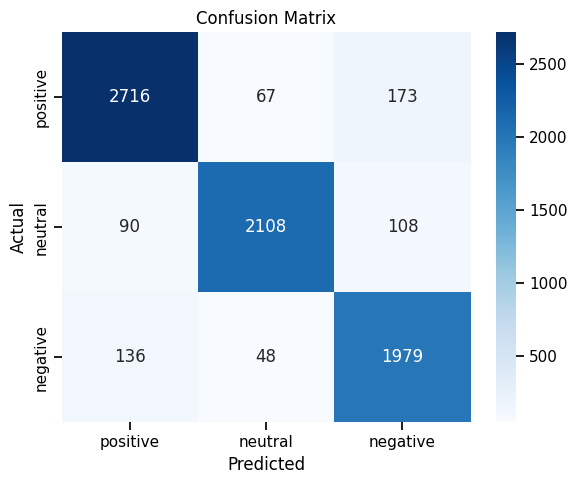

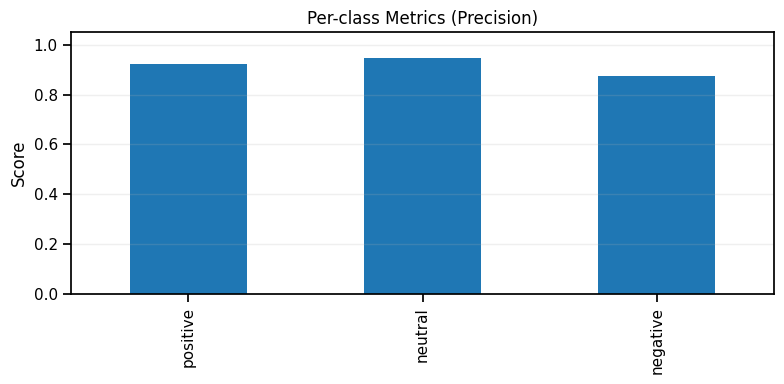

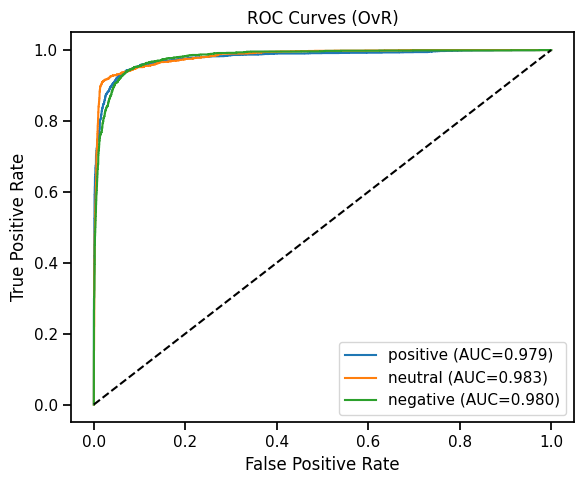

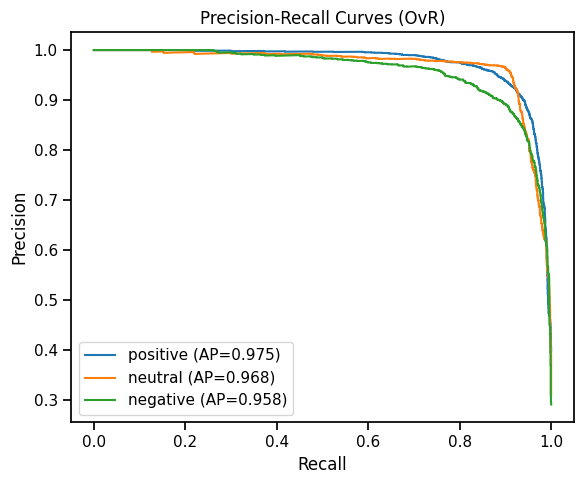

              precision    recall  f1-score   support

    positive     0.9232    0.9188    0.9210      2956
     neutral     0.9483    0.9141    0.9309      2306
    negative     0.8757    0.9149    0.8949      2163

    accuracy                         0.9162      7425
   macro avg     0.9157    0.9160    0.9156      7425
weighted avg     0.9171    0.9162    0.9165      7425



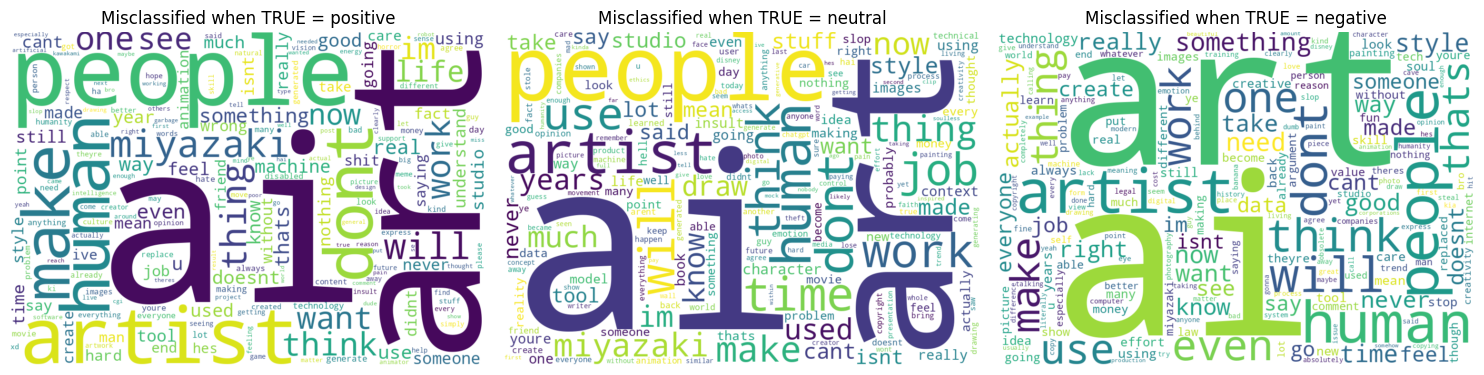

Done. CV grid (train pool) + Final Test evaluation complete. Outputs saved to: /content/drive/MyDrive/sentiment analysis/thesis_outputs


In [ ]:
# ===========================
# roberta-base THESIS-GRADE SENTIMENT PIPE (REVISED + MINI GRID SEARCH)
# ===========================
# Proper order:
# 1) Split once -> (TrainPool 80%) + (Hold-out Test 20%)
# 2) K-Fold CV ONLY on TrainPool (no peeking at Test) with a tiny LR/EPOCHS grid
# 3) Pick best (LR, EPOCHS) by mean CV F1
# 4) Retrain final model on TrainPool (with small Val split & Early Stop) using best HP
# 5) Evaluate ONCE on Test; save plots + reports

# !pip install --upgrade pyarrow
# !pip install -U datasets transformers accelerate evaluate scikit-learn matplotlib seaborn wordcloud

import os, json, random, math, itertools, gc
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments,
    EarlyStoppingCallback, set_seed
)
from transformers.trainer import Trainer as HFTrainer
import torch.nn.functional as F

# ------------ PATHS / SETTINGS ------------
DATA_CSV   = "/content/drive/MyDrive/sentiment analysis/cleaned_ghibli_dataset_preprocessed.csv"
SAVE_DIR   = "/content/drive/MyDrive/sentiment analysis/thesis_outputs"
MODEL_NAME = "roberta-base"   # alternatives: "bert-base-uncased", "distilbert-base-uncased"
MAX_LEN    = 256               # try 256 if comments are longer
# Default values (used if grid not selected). Will be overridden by best values after CV.
EPOCHS     = 4
LR         = 2e-5
TRAIN_BS   = 16
EVAL_BS    = 32
SEED       = 42
KFOLDS     = 5

os.makedirs(SAVE_DIR, exist_ok=True)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sns.set_context("notebook")

def savefig(name):
    plt.savefig(os.path.join(SAVE_DIR, f"{name}.png"), dpi=240, bbox_inches="tight")

# ------------ LOAD DATA ------------
df = pd.read_csv(DATA_CSV)
assert {"clean_text", "sentiment"}.issubset(df.columns), "CSV must have 'clean_text' and 'sentiment' columns"
df["clean_text"] = df["clean_text"].fillna("").astype(str)

label_map = {"positive":0, "neutral":1, "negative":2}
df["label"] = df["sentiment"].map(label_map).astype(int)

# ------------ SINGLE HOLD-OUT SPLIT (Test is sacred) ------------
if "source" in df.columns:
    strat_key = df["label"].astype(str) + "_" + df["source"].astype(str)
else:
    strat_key = df["label"]

idx_trainpool, idx_test = train_test_split(
    np.arange(len(df)), test_size=0.20, random_state=SEED, stratify=strat_key
)

trainpool_df = df.iloc[idx_trainpool].reset_index(drop=True)
test_df      = df.iloc[idx_test].reset_index(drop=True)

# Keep raw test texts/sources for error analysis
test_texts   = test_df["clean_text"].tolist()
test_sources = test_df["source"].tolist() if "source" in test_df.columns else None

# ------------ TOKENIZER ------------
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tok(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=MAX_LEN)

# ------------ LABEL DICTS ------------
id2label = {0:"positive", 1:"neutral", 2:"negative"}
label2id = {v:k for k,v in id2label.items()}

# ------------ UTILS ------------
def make_hfds(texts, labels):
    return Dataset.from_dict({"text": texts, "labels": labels}).map(tok, batched=True)

class WeightedTrainer(HFTrainer):
    """Uses self.class_weights if set; otherwise falls back to uniform."""
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.get("labels")
        outputs = model(**inputs)
        logits  = outputs.get("logits")
        if labels is not None:
            cw = getattr(self, "class_weights", None)
            if cw is None:
                n = model.config.num_labels
                cw = torch.ones(n, dtype=torch.float, device=model.device)
            loss = F.cross_entropy(logits, labels, weight=cw.to(model.device))
        else:
            loss = outputs.get("loss", None)
        return (loss, outputs) if return_outputs else loss

# Common metric fn
def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# ------------ K-FOLD ONLY ON TRAIN POOL + MINI GRID SEARCH ------------
texts_all  = trainpool_df["clean_text"].astype(str).tolist()
labels_all = trainpool_df["label"].astype(int).tolist()

# Tiny, Colab-friendly grid (you can expand lightly if time allows)
lr_grid      = [1e-5, 2e-5, 3e-5]
epochs_grid  = [3, 4]

skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)

# We'll track per-(lr,epochs) results aggregated across folds
hp_results = []   # list of dicts: {lr, epochs, fold, eval_*}

print("Running K-Fold Cross-Validation with Mini Grid Search on TrainPool ...")

for lr_candidate in lr_grid:
    for epochs_candidate in epochs_grid:
        fold_finals = []
        print(f"### HP Combo: LR={lr_candidate} | EPOCHS={epochs_candidate} ###")

        for fold_id, (tr_idx, va_idx) in enumerate(skf.split(texts_all, labels_all), start=1):
            print(f"=== Fold {fold_id}/{KFOLDS} ===")

            tr_texts = [texts_all[i] for i in tr_idx]
            tr_labs  = [labels_all[i] for i in tr_idx]
            va_texts = [texts_all[i] for i in va_idx]
            va_labs  = [labels_all[i] for i in va_idx]

            tr_ds = make_hfds(tr_texts, tr_labs)
            va_ds = make_hfds(va_texts, va_labs)

            # fresh model per fold
            fold_model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
            )

            # per-fold class weights
            counts = np.bincount(tr_labs, minlength=3)
            cw     = (1.0 / (counts + 1e-9))
            cw     = cw / cw.sum() * 3
            cw_t   = torch.tensor(cw, dtype=torch.float)

            fold_args = TrainingArguments(
                output_dir=os.path.join(SAVE_DIR, f"results_cv/fold{fold_id}_lr{lr_candidate}_ep{epochs_candidate}"),
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                learning_rate=lr_candidate,
                per_device_train_batch_size=TRAIN_BS,
                per_device_eval_batch_size=EVAL_BS,
                num_train_epochs=epochs_candidate,
                weight_decay=0.01,
                fp16=True,
                logging_strategy="steps",
                logging_steps=50,
                report_to=[]
            )

            trainer = WeightedTrainer(
                model=fold_model,
                args=fold_args,
                train_dataset=tr_ds,
                eval_dataset=va_ds,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )
            trainer.class_weights = cw_t

            set_seed(SEED + fold_id)
            trainer.train()

            logs = pd.DataFrame(trainer.state.log_history)
            ev   = logs.loc[logs["eval_loss"].notna(), ["epoch","eval_loss","eval_accuracy","eval_precision","eval_recall","eval_f1"]].copy()

            # best epoch for this fold under this HP combo
            best_row = ev.sort_values("eval_f1", ascending=False).iloc[0].to_dict()
            best_row.update({"lr": lr_candidate, "epochs": epochs_candidate, "fold": fold_id})
            fold_finals.append(best_row)
            hp_results.append(best_row)

            # cleanup
            del trainer, fold_model, tr_ds, va_ds
            gc.collect(); torch.cuda.empty_cache()

        # summarize per-HP across folds
        hp_df = pd.DataFrame(fold_finals)
        print("HP mean across folds:")
        for metric in ["eval_accuracy","eval_precision","eval_recall","eval_f1"]:
            print(f"- {metric[5:]}: {hp_df[metric].mean():.4f} ± {hp_df[metric].std():.4f}")

# Choose best HP by mean eval_f1 across folds
hp_all = pd.DataFrame(hp_results)
agg = hp_all.groupby(["lr","epochs"]).agg({"eval_f1":["mean","std"],
                                             "eval_accuracy":"mean",
                                             "eval_precision":"mean",
                                             "eval_recall":"mean"}).reset_index()
agg.columns = ["lr","epochs","f1_mean","f1_std","acc_mean","prec_mean","rec_mean"]
agg = agg.sort_values(["f1_mean","acc_mean","prec_mean","rec_mean"], ascending=False)

best_lr = float(agg.iloc[0]["lr"])
best_epochs = int(agg.iloc[0]["epochs"])
print(f">>> Selected BEST HP: LR={best_lr} | EPOCHS={best_epochs} (by CV f1_mean)")

# Save full HP table
agg.to_csv(os.path.join(SAVE_DIR, "cv_hp_grid_summary.csv"), index=False)

# We also persist a compact summary for quick reading
with open(os.path.join(SAVE_DIR, "cv_hp_best.json"), "w") as f:
    json.dump({
        "best_lr": best_lr,
        "best_epochs": best_epochs,
        "table_head": ["lr","epochs","f1_mean","f1_std","acc_mean","prec_mean","rec_mean"],
        "top5": agg.head(5).to_dict(orient="records")
    }, f, indent=2)

# ------------ FINAL TRAIN ON FULL TRAIN POOL (with small Val split) ------------
if "source" in trainpool_df.columns:
    strat_key_tv = trainpool_df["label"].astype(str) + "_" + trainpool_df["source"].astype(str)
else:
    strat_key_tv = trainpool_df["label"]

idx_tr, idx_val = train_test_split(
    np.arange(len(trainpool_df)), test_size=0.10, random_state=SEED, stratify=strat_key_tv
)

train_split = trainpool_df.iloc[idx_tr].reset_index(drop=True)
val_split   = trainpool_df.iloc[idx_val].reset_index(drop=True)

train_ds = make_hfds(train_split["clean_text"].tolist(), train_split["label"].tolist())
val_ds   = make_hfds(val_split["clean_text"].tolist(),   val_split["label"].tolist())

global_counts = train_split["label"].value_counts().sort_index().reindex([0,1,2], fill_value=0).values
class_weights = (1.0 / (global_counts + 1e-9))
class_weights = class_weights / class_weights.sum() * 3
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
)

args = TrainingArguments(
    output_dir=os.path.join(SAVE_DIR, "results_main"),
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=best_lr,  # use best LR from CV
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=best_epochs,  # max epochs from CV; EarlyStopping picks best
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=1,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    logging_dir=os.path.join(SAVE_DIR, "logs"),
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[]
)

trainer = WeightedTrainer(
    model=final_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.class_weights = class_weights_t

train_output = trainer.train()

# ------------ TEST EVAL & PLOTS (SINGLE FINAL TEST) ------------
# build test ds
test_ds = make_hfds(test_df["clean_text"].tolist(), test_df["label"].tolist())

preds_output = trainer.predict(test_ds)
y_logits = preds_output.predictions
y_prob   = torch.softmax(torch.tensor(y_logits), dim=1).numpy()
y_pred   = y_prob.argmax(1)
y_true   = np.array(test_df["label"].tolist())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in [0,1,2]],
            yticklabels=[id2label[i] for i in [0,1,2]])
plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
savefig("confusion_matrix"); plt.tight_layout(); plt.show()

# Per-class bars (precision)
p_c, r_c, f1_c, sup_c = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2], zero_division=0)
per_df = pd.DataFrame({"class":[id2label[i] for i in [0,1,2]], "precision":p_c, "recall":r_c, "f1":f1_c, "support":sup_c})
per_df.set_index("class")["precision"].plot(kind="bar", figsize=(8,4))
plt.title("Per-class Metrics (Precision)"); plt.ylim(0,1.05); plt.xlabel(""); plt.ylabel("Score"); plt.grid(axis="y", alpha=.2)
savefig("per_class_bars_precision"); plt.tight_layout(); plt.show()

# ROC/PR (one-vs-rest)
classes = [0,1,2]
y_true_bin = label_binarize(y_true, classes=classes)

plt.figure(figsize=(6,5))
for i in classes:
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--"); plt.title("ROC Curves (OvR)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
savefig("roc_ovr"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
for i in classes:
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{id2label[i]} (AP={ap:.3f})")
plt.title("Precision-Recall Curves (OvR)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
savefig("pr_ovr"); plt.tight_layout(); plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=[id2label[i] for i in classes], digits=4, zero_division=0)
print(report)
with open(os.path.join(SAVE_DIR, "classification_report.txt"), "w") as f:
    f.write(report)

# ------------ PER-SOURCE METRICS (Twitter vs YouTube) ------------
if test_sources is not None:
    src_arr = np.array(test_sources)
    for src in sorted(pd.unique(src_arr)):
        idx = np.where(src_arr == src)[0]
        if len(idx) == 0: continue
        yt, yp = y_true[idx], y_pred[idx]
        p, r, f1, _ = precision_recall_fscore_support(yt, yp, average="weighted", zero_division=0)
        acc = accuracy_score(yt, yp)
        print(f"=== {src.upper()} TEST ===")
        print(f"acc={acc:.4f}  p={p:.4f}  r={r:.4f}  f1={f1:.4f}")
        with open(os.path.join(SAVE_DIR, f"report_{src}.txt"), "w") as f:
            f.write(classification_report(yt, yp, target_names=[id2label[i] for i in classes], digits=4, zero_division=0))

# ------------ ERROR WORDCLOUDS (true-class buckets) ------------
stop = set(STOPWORDS) | {"rt","http","https","co","amp","ghibli","openai","image","video"}
mis_by_true = {c: [] for c in classes}
for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt != yp:
        mis_by_true[yt].append(test_texts[i])

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for idx, c in enumerate(classes):
    blob = " ".join(mis_by_true[c]) if mis_by_true[c] else "no errors"
    wc = WordCloud(width=1000, height=700, background_color="white",
                   stopwords=stop, collocations=False, max_words=200).generate(blob)
    axes[idx].imshow(wc, interpolation="bilinear"); axes[idx].axis("off")
    axes[idx].set_title(f"Misclassified when TRUE = {id2label[c]}")
savefig("wordcloud_true_class"); plt.tight_layout(); plt.show()

# ------------ SAVE KEY ARTIFACTS ------------
trainer.model.save_pretrained(os.path.join(SAVE_DIR, "best_model"))
tokenizer.save_pretrained(os.path.join(SAVE_DIR, "best_model"))

with open(os.path.join(SAVE_DIR, "train_eval_summary.json"), "w") as f:
    json.dump({
        "best_lr": best_lr,
        "best_epochs": best_epochs,
        "model_name": MODEL_NAME,
        "max_len": MAX_LEN,
        "train_size": int(len(trainpool_df)),
        "test_size": int(len(test_df))
    }, f, indent=2)

print("Done. CV grid (train pool) + Final Test evaluation complete. Outputs saved to:", SAVE_DIR)


In [ ]:
# ===========================
# DISTILBERT SENTIMENT PIPE — RESEARCH WORKFLOW
# ===========================
# Features:
# • Clean train/val/test protocol (hold‑out test, no leakage)
# • K‑Fold CV on training pool ONLY (with mini LR/EPOCHS grid)
# • Class‑weighted loss (handles imbalance)
# • Early stopping + best‑model selection per fold
# • Full plotting suite: train loss, eval curves, LR schedule, confusion matrix,
#   per‑class bars, ROC/PR curves (OvR), CV mean±SD curves, reliability (calibration) plot,
#   wordclouds for misclassifications
# • Per‑source test metrics (e.g., Twitter vs YouTube)
# • Exports: CSVs + JSON summaries + model artifacts
# Colab Pro + T4 friendly

# !pip install --upgrade pyarrow
# !pip install -U datasets transformers accelerate evaluate scikit-learn matplotlib seaborn wordcloud

import os, json, gc, math, itertools, random
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments,
    EarlyStoppingCallback, set_seed
)
from transformers.trainer import Trainer as HFTrainer
import torch.nn.functional as F

# ===========================
# PATHS / SETTINGS
# ===========================
DATA_CSV   = "/content/drive/MyDrive/sentiment analysis/cleaned_ghibli_dataset_preprocessed.csv"
SAVE_DIR   = "/content/drive/MyDrive/sentiment analysis/thesis_outputs_distilbert"
MODEL_NAME = "distilbert-base-uncased"
MAX_LEN    = 128                 # try 256 if comments are long (VRAM permitting)
SEED       = 42
KFOLDS     = 5
TRAIN_BS   = 16                  # adjust if OOM
EVAL_BS    = 32

# Mini grid (Colab‑safe). You can expand slightly if time allows
LR_GRID     = [1e-5, 2e-5, 3e-5, 5e-5]
EPOCHS_GRID = [3, 4]

os.makedirs(SAVE_DIR, exist_ok=True)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
sns.set_context("notebook")

# ===========================
# HELPERS
# ===========================

def savefig(name):
    plt.savefig(os.path.join(SAVE_DIR, f"{name}.png"), dpi=240, bbox_inches="tight")

def to_device(t):
    return t.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Weighted Trainer that honors per‑fold weights if set
class WeightedTrainer(HFTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels  = inputs.get("labels")
        outputs = model(**inputs)
        logits  = outputs.get("logits")
        if labels is not None:
            cw = getattr(self, "class_weights", None)
            if cw is None:
                n = model.config.num_labels
                cw = torch.ones(n, dtype=torch.float, device=model.device)
            loss = F.cross_entropy(logits, labels, weight=cw.to(model.device))
        else:
            loss = outputs.get("loss", None)
        return (loss, outputs) if return_outputs else loss

# Common metrics

def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1}

# Tokenizer / HF datasets

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

def tok(batch):
    return tokenizer(batch["text"], padding=True, truncation=True, max_length=MAX_LEN)


def make_hfds(texts, labels):
    return Dataset.from_dict({"text": texts, "labels": labels}).map(tok, batched=True)

# Reliability (calibration) curve + ECE

def reliability_plot(probs, y_true, n_bins=10, title="Reliability Diagram", fname="reliability"):
    # probs: [N, C] predicted probabilities; we use max prob / predicted class correctness
    confidences = probs.max(axis=1)
    predictions = probs.argmax(axis=1)
    correct = (predictions == y_true).astype(float)

    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidences, bins) - 1

    bin_acc = []
    bin_conf = []
    bin_counts = []
    for b in range(n_bins):
        mask = (bin_ids == b)
        if mask.sum() > 0:
            bin_acc.append(correct[mask].mean())
            bin_conf.append(confidences[mask].mean())
            bin_counts.append(mask.sum())
        else:
            bin_acc.append(0.0)
            bin_conf.append((bins[b]+bins[b+1])/2)
            bin_counts.append(0)

    ece = 0.0
    N = len(y_true)
    for a, c, m in zip(bin_acc, bin_conf, bin_counts):
        ece += (m / N) * abs(a - c)

    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1], 'k--', label='Perfectly calibrated')
    plt.plot(bin_conf, bin_acc, marker='o', label='Model')
    plt.title(f"{title} (ECE={ece:.3f})")
    plt.xlabel("Mean Confidence")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, ls='--', alpha=.3)
    savefig(fname); plt.tight_layout(); plt.show()
    return ece

# ===========================
# LOAD DATA
# ===========================

df = pd.read_csv(DATA_CSV)
assert {"clean_text", "sentiment"}.issubset(df.columns), "CSV must have 'clean_text' and 'sentiment' columns"
df["clean_text"] = df["clean_text"].fillna("").astype(str)

label_map = {"positive":0, "neutral":1, "negative":2}
df["label"] = df["sentiment"].map(label_map).astype(int)

id2label = {0:"positive", 1:"neutral", 2:"negative"}
label2id = {v:k for k,v in id2label.items()}

# ===========================
# SINGLE HOLD‑OUT SPLIT (test is sacred)
# ===========================

if "source" in df.columns:
    strat_key = df["label"].astype(str) + "_" + df["source"].astype(str)
else:
    strat_key = df["label"]

idx_trainpool, idx_test = train_test_split(
    np.arange(len(df)), test_size=0.20, random_state=SEED, stratify=strat_key
)

trainpool_df = df.iloc[idx_trainpool].reset_index(drop=True)
test_df      = df.iloc[idx_test].reset_index(drop=True)

# Keep raw test texts/sources for error analysis
test_texts   = test_df["clean_text"].tolist()
test_sources = test_df["source"].tolist() if "source" in test_df.columns else None

# ===========================
# K‑FOLD CV ON TRAIN POOL + MINI GRID
# ===========================

texts_all  = trainpool_df["clean_text"].astype(str).tolist()
labels_all = trainpool_df["label"].astype(int).tolist()

skf = StratifiedKFold(n_splits=KFOLDS, shuffle=True, random_state=SEED)

hp_results = []  # store per‑fold best row for each (lr,epochs)
print("\nRunning K‑Fold Cross‑Validation with mini LR/EPOCHS grid on TrainPool ...")

for lr_candidate in LR_GRID:
    for epochs_candidate in EPOCHS_GRID:
        fold_finals = []
        print(f"\n### HP Combo: LR={lr_candidate} | EPOCHS={epochs_candidate} ###")
        for fold_id, (tr_idx, va_idx) in enumerate(skf.split(texts_all, labels_all), start=1):
            print(f"\n=== Fold {fold_id}/{KFOLDS} ===")

            tr_texts = [texts_all[i] for i in tr_idx]
            tr_labs  = [labels_all[i] for i in tr_idx]
            va_texts = [texts_all[i] for i in va_idx]
            va_labs  = [labels_all[i] for i in va_idx]

            tr_ds = make_hfds(tr_texts, tr_labs)
            va_ds = make_hfds(va_texts, va_labs)

            fold_model = AutoModelForSequenceClassification.from_pretrained(
                MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
            )

            # per‑fold class weights
            counts = np.bincount(tr_labs, minlength=3)
            cw     = (1.0 / (counts + 1e-9))
            cw     = cw / cw.sum() * 3
            cw_t   = torch.tensor(cw, dtype=torch.float)

            fold_args = TrainingArguments(
                output_dir=os.path.join(SAVE_DIR, f"cv/fold{fold_id}_lr{lr_candidate}_ep{epochs_candidate}"),
                eval_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="f1",
                greater_is_better=True,
                learning_rate=lr_candidate,
                per_device_train_batch_size=TRAIN_BS,
                per_device_eval_batch_size=EVAL_BS,
                num_train_epochs=epochs_candidate,
                weight_decay=0.01,
                fp16=True,
                logging_strategy="steps",
                logging_steps=50,
                report_to=[],
                remove_unused_columns=True,
            )

            trainer = WeightedTrainer(
                model=fold_model,
                args=fold_args,
                train_dataset=tr_ds,
                eval_dataset=va_ds,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )
            trainer.class_weights = cw_t

            set_seed(SEED + fold_id)
            train_output = trainer.train()

            # Logs and curves per fold/HP
            logs = pd.DataFrame(trainer.state.log_history)
            ev   = logs.loc[logs["eval_loss"].notna(), ["epoch","eval_loss","eval_accuracy","eval_precision","eval_recall","eval_f1"]].copy()

            # Best epoch row
            best_row = ev.sort_values("eval_f1", ascending=False).iloc[0].to_dict()
            best_row.update({"lr": lr_candidate, "epochs": epochs_candidate, "fold": fold_id})
            fold_finals.append(best_row)
            hp_results.append(best_row)

            # Optional: per‑fold plots
            # Training loss over steps
            tl = logs.loc[logs["loss"].notna(), ["step","loss"]].rename(columns={"loss":"train_loss"})
            if not tl.empty:
                plt.figure(figsize=(7,4)); plt.plot(tl["step"], tl["train_loss"])
                plt.title(f"Training Loss (Fold {fold_id}, LR={lr_candidate}, EP={epochs_candidate})")
                plt.xlabel("Step"); plt.ylabel("Loss"); plt.grid(True, ls="--", alpha=.3)
                savefig(f"train_loss_steps_fold{fold_id}_lr{lr_candidate}_ep{epochs_candidate}")
                plt.show()

            # Eval curves per epoch
            if not ev.empty:
                fig, axes = plt.subplots(1,4, figsize=(18,4))
                axes[0].plot(ev["epoch"], ev["eval_loss"], marker="o"); axes[0].set_title("Val Loss")
                axes[1].plot(ev["epoch"], ev["eval_accuracy"], marker="o"); axes[1].set_title("Acc")
                axes[2].plot(ev["epoch"], ev["eval_precision"], marker="o"); axes[2].set_title("Prec (w)")
                axes[3].plot(ev["epoch"], ev["eval_f1"], marker="o"); axes[3].set_title("F1 (w)")
                for ax in axes: ax.set_xlabel("Epoch"); ax.grid(True, ls="--", alpha=.3)
                savefig(f"eval_curves_fold{fold_id}_lr{lr_candidate}_ep{epochs_candidate}")
                plt.tight_layout(); plt.show()

            # Cleanup
            del trainer, fold_model, tr_ds, va_ds
            gc.collect(); torch.cuda.empty_cache()

        # Summary for this HP combo
        hp_df = pd.DataFrame(fold_finals)
        print("HP mean across folds:")
        for metric in ["eval_accuracy","eval_precision","eval_recall","eval_f1"]:
            print(f"- {metric[5:]}: {hp_df[metric].mean():.4f} ± {hp_df[metric].std():.4f}")

# Aggregate over all HP combos
hp_all = pd.DataFrame(hp_results)
agg = hp_all.groupby(["lr","epochs"]).agg({
    "eval_f1":["mean","std"],
    "eval_accuracy":"mean",
    "eval_precision":"mean",
    "eval_recall":"mean"
}).reset_index()
agg.columns = ["lr","epochs","f1_mean","f1_std","acc_mean","prec_mean","rec_mean"]
agg = agg.sort_values(["f1_mean","acc_mean","prec_mean","rec_mean"], ascending=False)

best_lr    = float(agg.iloc[0]["lr"])
best_epochs= int(agg.iloc[0]["epochs"])
print(f"\n>>> Selected BEST HP: LR={best_lr} | EPOCHS={best_epochs} (by CV f1_mean)")

agg.to_csv(os.path.join(SAVE_DIR, "cv_hp_grid_summary.csv"), index=False)
with open(os.path.join(SAVE_DIR, "cv_hp_best.json"), "w") as f:
    json.dump({
        "best_lr": best_lr,
        "best_epochs": best_epochs,
        "table_head": ["lr","epochs","f1_mean","f1_std","acc_mean","prec_mean","rec_mean"],
        "top5": agg.head(5).to_dict(orient="records")
    }, f, indent=2)

# ===========================
# FINAL TRAIN ON TRAIN POOL (small val split) USING BEST HP
# ===========================

if "source" in trainpool_df.columns:
    strat_key_tv = trainpool_df["label"].astype(str) + "_" + trainpool_df["source"].astype(str)
else:
    strat_key_tv = trainpool_df["label"]

idx_tr, idx_val = train_test_split(
    np.arange(len(trainpool_df)), test_size=0.10, random_state=SEED, stratify=strat_key_tv
)

train_split = trainpool_df.iloc[idx_tr].reset_index(drop=True)
val_split   = trainpool_df.iloc[idx_val].reset_index(drop=True)

train_ds = make_hfds(train_split["clean_text"].tolist(), train_split["label"].tolist())
val_ds   = make_hfds(val_split["clean_text"].tolist(),   val_split["label"].tolist())

# Class weights on final train split
global_counts = train_split["label"].value_counts().sort_index().reindex([0,1,2], fill_value=0).values
class_weights = (1.0 / (global_counts + 1e-9))
class_weights = class_weights / class_weights.sum() * 3
class_weights_t = torch.tensor(class_weights, dtype=torch.float)

final_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=3, id2label=id2label, label2id=label2id
)

args = TrainingArguments(
    output_dir=os.path.join(SAVE_DIR, "results_main"),
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    learning_rate=best_lr,
    per_device_train_batch_size=TRAIN_BS,
    per_device_eval_batch_size=EVAL_BS,
    num_train_epochs=best_epochs,
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=1,
    warmup_ratio=0.06,
    lr_scheduler_type="cosine",
    logging_dir=os.path.join(SAVE_DIR, "logs"),
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],
    remove_unused_columns=True,
)

trainer = WeightedTrainer(
    model=final_model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.class_weights = class_weights_t

train_output = trainer.train()

# Plots from final training
logs = pd.DataFrame(trainer.state.log_history)

# Train loss over steps
if not logs.loc[logs["loss"].notna()].empty:
    tl = logs.loc[logs["loss"].notna(), ["step","loss"]].rename(columns={"loss":"train_loss"})
    plt.figure(figsize=(7,4)); plt.plot(tl["step"], tl["train_loss"])
    plt.title("Training Loss over Steps"); plt.xlabel("Step"); plt.ylabel("Loss"); plt.grid(True, ls="--", alpha=.3)
    savefig("train_loss_steps_final"); plt.show()

# Eval curves over epochs
ev = logs.loc[logs["eval_loss"].notna(), ["epoch","eval_loss","eval_accuracy","eval_precision","eval_recall","eval_f1"]]
if not ev.empty:
    fig, axes = plt.subplots(1,4, figsize=(18,4))
    axes[0].plot(ev["epoch"], ev["eval_loss"], marker="o"); axes[0].set_title("Validation Loss")
    axes[1].plot(ev["epoch"], ev["eval_accuracy"], marker="o"); axes[1].set_title("Accuracy")
    axes[2].plot(ev["epoch"], ev["eval_precision"], marker="o"); axes[2].set_title("Precision (w)")
    axes[3].plot(ev["epoch"], ev["eval_f1"], marker="o"); axes[3].set_title("F1 (w)")
    for ax in axes: ax.set_xlabel("Epoch"); ax.grid(True, ls="--", alpha=.3)
    savefig("eval_curves_epochs_final"); plt.tight_layout(); plt.show()

# Learning rate over steps
lr = logs.loc[logs["learning_rate"].notna(), ["step","learning_rate"]]
if not lr.empty:
    plt.figure(figsize=(7,4)); plt.plot(lr["step"], lr["learning_rate"])
    plt.title("Learning Rate over Steps"); plt.xlabel("Step"); plt.ylabel("LR"); plt.grid(True, ls="--", alpha=.3)
    savefig("learning_rate_steps_final"); plt.show()

# ===========================
# FINAL TEST EVALUATION (single, untouched test)
# ===========================

classes = [0,1,2]

test_ds = make_hfds(test_df["clean_text"].tolist(), test_df["label"].tolist())
preds_output = trainer.predict(test_ds)
y_logits = preds_output.predictions
y_prob   = torch.softmax(torch.tensor(y_logits), dim=1).numpy()
y_pred   = y_prob.argmax(1)
y_true   = np.array(test_df["label"].tolist())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id2label[i] for i in classes],
            yticklabels=[id2label[i] for i in classes])
plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("Actual")
savefig("confusion_matrix_test"); plt.tight_layout(); plt.show()

# Per‑class bars
p_c, r_c, f1_c, sup_c = precision_recall_fscore_support(y_true, y_pred, labels=classes, zero_division=0)
per_df = pd.DataFrame({"class":[id2label[i] for i in classes], "precision":p_c, "recall":r_c, "f1":f1_c, "support":sup_c})
per_df.set_index("class")["precision"].plot(kind="bar", figsize=(8,4))
plt.title("Per‑class Precision (Test)"); plt.ylim(0,1.05); plt.xlabel(""); plt.ylabel("Score"); plt.grid(axis="y", alpha=.2)
savefig("per_class_precision_test"); plt.tight_layout(); plt.show()

per_df.set_index("class")["f1"].plot(kind="bar", figsize=(8,4))
plt.title("Per‑class F1 (Test)"); plt.ylim(0,1.05); plt.xlabel(""); plt.ylabel("F1"); plt.grid(axis="y", alpha=.2)
savefig("per_class_f1_test"); plt.tight_layout(); plt.show()

# ROC/PR (OvR)
y_true_bin = label_binarize(y_true, classes=classes)

plt.figure(figsize=(6,5))
for i in classes:
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],"k--"); plt.title("ROC Curves (OvR, Test)")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.legend()
savefig("roc_ovr_test"); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,5))
for i in classes:
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_prob[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{id2label[i]} (AP={ap:.3f})")
plt.title("Precision‑Recall Curves (OvR, Test)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
savefig("pr_ovr_test"); plt.tight_layout(); plt.show()

# Reliability (calibration)
ece = reliability_plot(y_prob, y_true, n_bins=10, title="Reliability (Test)", fname="reliability_test")

# Classification report
report = classification_report(y_true, y_pred, target_names=[id2label[i] for i in classes], digits=4, zero_division=0)
print(report)
with open(os.path.join(SAVE_DIR, "classification_report_test.txt"), "w") as f:
    f.write(report)

# Per‑source metrics (e.g., Twitter vs YouTube)
if test_sources is not None:
    src_arr = np.array(test_sources)
    src_rows = []
    for src in sorted(pd.unique(src_arr)):
        idx = np.where(src_arr == src)[0]
        if len(idx) == 0: continue
        yt, yp = y_true[idx], y_pred[idx]
        p, r, f1, _ = precision_recall_fscore_support(yt, yp, average="weighted", zero_division=0)
        acc = accuracy_score(yt, yp)
        src_rows.append({"source":src, "acc":acc, "precision":p, "recall":r, "f1":f1, "n":len(idx)})
        with open(os.path.join(SAVE_DIR, f"report_{src}_test.txt"), "w") as f:
            f.write(classification_report(yt, yp, target_names=[id2label[i] for i in classes], digits=4, zero_division=0))
    if src_rows:
        pd.DataFrame(src_rows).to_csv(os.path.join(SAVE_DIR, "per_source_metrics_test.csv"), index=False)

# Error wordclouds by TRUE class
stop = set(STOPWORDS) | {"rt","http","https","co","amp","ghibli","openai","image","video"}
mis_by_true = {c: [] for c in classes}
for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
    if yt != yp:
        mis_by_true[yt].append(test_texts[i])

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for idx, c in enumerate(classes):
    blob = " ".join(mis_by_true[c]) if mis_by_true[c] else "no errors"
    wc = WordCloud(width=1000, height=700, background_color="white",
                   stopwords=stop, collocations=False, max_words=200).generate(blob)
    axes[idx].imshow(wc, interpolation="bilinear"); axes[idx].axis("off")
    axes[idx].set_title(f"Misclassified when TRUE = {id2label[c]}")
savefig("wordcloud_true_class_test"); plt.tight_layout(); plt.show()

# Save top misclassified examples
probs_max = y_prob.max(axis=1)
mis_rows = []
for txt, yt, yp, pm in zip(test_texts, y_true, y_pred, probs_max):
    if yt != yp:
        mis_rows.append({
            "text": txt,
            "true": id2label[int(yt)],
            "pred": id2label[int(yp)],
            "pred_prob": float(pm)
        })
if mis_rows:
    pd.DataFrame(mis_rows).to_csv(os.path.join(SAVE_DIR, "misclassified_examples_test.csv"), index=False)

# ===========================
# EXPORT ARTIFACTS
# ===========================

# Save model & tokenizer
trainer.model.save_pretrained(os.path.join(SAVE_DIR, "best_model"))
tokenizer.save_pretrained(os.path.join(SAVE_DIR, "best_model"))

# Save compact summary JSON
with open(os.path.join(SAVE_DIR, "train_eval_summary.json"), "w") as f:
    json.dump({
        "best_lr": best_lr,
        "best_epochs": best_epochs,
        "model_name": MODEL_NAME,
        "max_len": MAX_LEN,
        "train_size": int(len(trainpool_df)),
        "test_size": int(len(test_df)),
        "ece_test": float(ece)
    }, f, indent=2)

print("\n✅ Done. DistilBERT CV grid (train pool) + Final Test evaluation complete. Outputs saved to:", SAVE_DIR)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-2131892653.py", line 156, in <cell line: 0>
    df = pd.read_csv(DATA_CSV)
         ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pandas/io/parsers/

TypeError: object of type 'NoneType' has no len()